# Prediction of Car Prices

#  Content

[Project Summary](#1) <br>
[Data Description and Retrieval](#2) <br>
[Exploratory Data Analysis](#3) <br>
[Default Values For Empty Fields](#7)<br>
[Categorical And Numerical Features](#4) <br>
[Car Price Prediction With XGBoost Regression](#5) <br>
[Model Finetuning And Testing](#6) <br>

## Project Summary <a id='1'></a>

The objective of this project is to develop a web application that uses a predictive model for estimating car prices in the European marker based on various vehicle attributes. Data for the project was sourced through API requests to Carvago, a leading car aggregator platform, and subsequently stored in a MySQL database. An initial exploratory data analysis was conducted to identify key features likely to impact the price of a car. This notebook focuces on feature exploration and model training.

For the predictive modeling XGBoost regression was chosen because this model showed comparable performance to neural-network based models in similar tasks and is better optimized for handling datasets with multiple correlated features and missing values, thereby requiring less preprocessin. The model was improved by selecting best hyperparameters using grid search technique.

The final XGBoost model exhibited strong performance in predicting car prices on a test set comprising 215,211 items. The model achieved a Root Mean Square Error (RMSE) of 3,086 on the test set. This implies that, on average, the model's price estimations deviated from the actual listing prices by approximately 3,000 EUR.

In [22]:
#Importing all necessary libraries and modules
import mysql.connector
from tqdm import tqdm
import datetime
from sqlalchemy import create_engine, Column, Integer, String, Table, MetaData, select, update, DateTime
from sqlalchemy import desc
import pandas as pd
from sqlalchemy import create_engine
import pandas as pd
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap 
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
import pickle
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
#fixing aspect ratio for charts
ASPECT = 2

In [3]:
def build_histogram(data, col_name):
    # functions prints out the histogram for a column in the provided dataframe
    
    plt.figure(figsize=(16, 6)) 
    sns.histplot(data=data[col_name],  kde=True).set_title(col_name)
    plt.show()

In [4]:
def connect_to_database():
    # Establish a database connection and return the connection object
    connection = mysql.connector.connect(
        host="127.0.0.1",
        user="root",
        password="Sk121212",
        database="car_analytics"
    )
    
    return connection

connection = connect_to_database()


# Data Description and Retrieval <a id='2'></a>
The data for this work is stored in a MySQL database created by the author of the work. The data includes the following tables:

**data** - the main dataset with price and with car caracteristics. Every row in the table represents one unique car listing. Some characteristics are indicated with id instead of a full name for memory optimization. The full names of characteristics are stored in the tables listed below. <br>
**fuel_type** - ids and names of fuel types <br>
**car_style**- ids and names of car styles <br>
**drive** - ids and names of drive type <br>
**emission_class** - ids and names of emission class <br>
**make**- ids and names of make (brand) <br>
**model**- ids and names of models <br>
**transmission**- ids and names of transmission type <br>
**features**- ids and names of additional features and functionalities such as climate control, camera, etc.

The code below is used to connect the the database and retireve data from the tables and store it in dataframes.

In [26]:
query = '''SELECT 
CUBIC_CAPACITY, 
POWER, 
NUMBER_OF_SEATS, 
FUEL_CONSUMPTION_URBAN, 
FUEL_CONSUMPTION_EXTRA_URBAN, 
FUEL_CONSUMPTION_COMBINED, 
POWER_UNIT, 
WEIGHT, 
NUMBER_OF_GEARS, 
CARBON_DIOXIDE_EMISSION, 
MANUFACTURE_DATE, 
VEHICLE_CLASS, 
PRICE, 
VAT_RECLAIMABLE, 
POWER_HP, 
CREATED_ON, 
FEATURES_ID, 
FUEL_TYPE_ID, 
CAR_STYLE_ID, 
EMISSION_CLASS_ID, 
DRIVE_ID, 
MAKE_LABEL, 
MODEL, 
TRANSMISSION_ID, 
PRICE_CURRENCY, 
SELLER_TYPE, 
SELLER_COUNTRY, 
MILEAGE, 
INTERIOR_MATERIAL FROM CARS'''

query_fuel = "SELECT * FROM FUEL_TYPE"
query_car_style = "SELECT * FROM CAR_STYLE"
query_drive = "SELECT * FROM DRIVE"
query_emission_class = "SELECT * FROM EMISSION_CLASS"
query_make = "SELECT * FROM MAKE"
query_model = "SELECT * FROM MODEL"
query_transmission = "SELECT * FROM TRANSMISSION"
query_features = "SELECT * FROM FEATURES"

# Retrieve data from MySQL and store it in a pandas DataFrame
data = pd.read_sql(query, connection)
fuel_type = pd.read_sql(query_fuel, connection)
car_style = pd.read_sql(query_car_style, connection)
drive = pd.read_sql(query_drive, connection)
emission_class = pd.read_sql(query_emission_class, connection)
make = pd.read_sql(query_make, connection)
model = pd.read_sql(query_model, connection)
transmission = pd.read_sql(query_transmission, connection)
features = pd.read_sql(query_features, connection)

The resulting dataset contains 717 369 items. Some columns contain missing values. Since all columns contain sufficient number of non-null values, I do not exclude any columns from the analysis. I do not treat missing values at this stage manually, because XGBoost algorithm handles such cases automatically. this issue is addressed in the chapter where I predict prices using a neural network,

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717370 entries, 0 to 717369
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   CUBIC_CAPACITY                674426 non-null  float64       
 1   POWER                         717370 non-null  int64         
 2   NUMBER_OF_SEATS               684701 non-null  float64       
 3   FUEL_CONSUMPTION_URBAN        447150 non-null  float64       
 4   FUEL_CONSUMPTION_EXTRA_URBAN  447661 non-null  float64       
 5   FUEL_CONSUMPTION_COMBINED     673581 non-null  float64       
 6   POWER_UNIT                    717370 non-null  object        
 7   WEIGHT                        150625 non-null  float64       
 8   NUMBER_OF_GEARS               143788 non-null  float64       
 9   CARBON_DIOXIDE_EMISSION       691322 non-null  float64       
 10  MANUFACTURE_DATE              717370 non-null  object        
 11  VEHICLE_CLASS

Some data needed minor corrections which are implemented in the cell below. The price currency is converted from CAK to EUR, manufacture year is calculated based on the car manufacture date, data type of milieage is changed to fload and vehicle class name is corrected.

In [6]:
#converting currency from CZK to EUR
CZK_TO_EUR = 0.041
data['PRICE_EUR'] = data['PRICE'] * CZK_TO_EUR

#extracting manufaxture year from th manufacture date
data['MANUFACTURE_YEAR'] = pd.to_datetime(data['MANUFACTURE_DATE']).dt.year
data['MANUFACTURE_YEAR'] = data['MANUFACTURE_YEAR'].astype(int)
data['MILEAGE'] = data['MILEAGE'].astype(float)
data['VEHICLE_CLASS'] = data['VEHICLE_CLASS'].fillna('NO').apply(lambda x: x.replace('CLASS_', ''))
data['FEATURE_NUM'] = data['FEATURES_ID'].apply(lambda x: len(x))

# Exploratory Data Analysis <a id='3'></a>

In this section We look at the distributions of existing variables and their relationship with price.

### Target Variable - Price

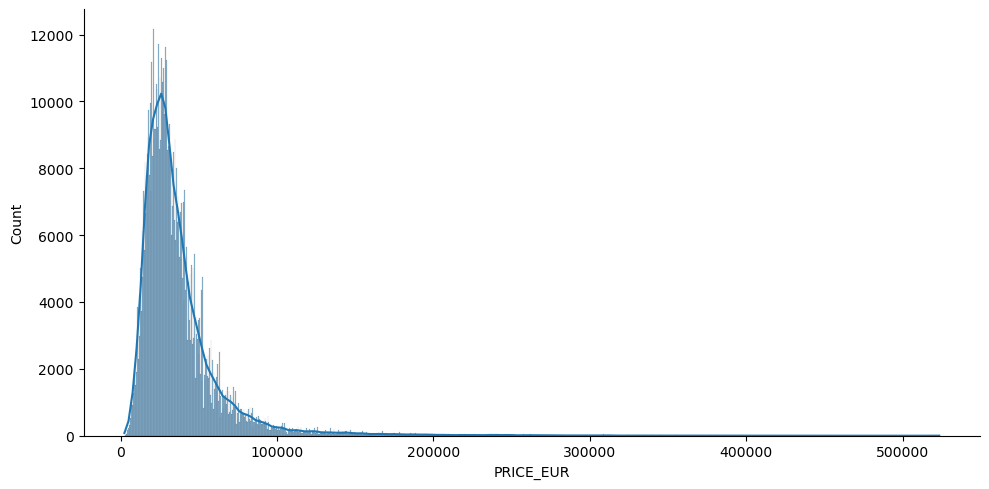

In [147]:
sns.displot(data['PRICE_EUR'], kde=True, aspect = ASPECT)

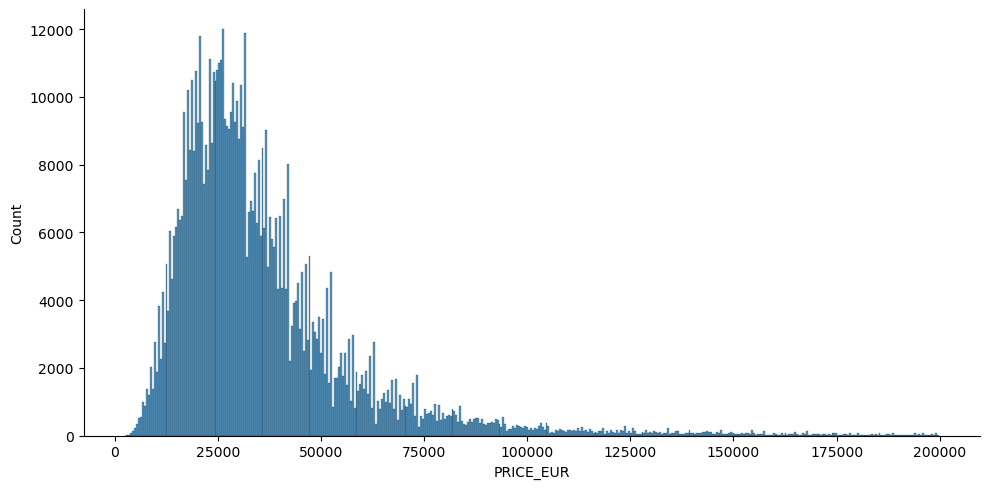

In [148]:
sns.displot(data[data['PRICE_EUR']< 200000]['PRICE_EUR'], aspect = ASPECT)

### Make
The make stands for the car brand. For the moment, there are 77 brands presented in the dataset. Below we show box-plots with prices of top 10 brands by number of cars in the dataset.


In [61]:
top_10_makes = data.groupby(['MAKE_LABEL'])[['PRICE']].count().sort_values(by = 'PRICE', ascending = False).head(10)

<AxesSubplot:xlabel='MAKE_LABEL', ylabel='PRICE'>

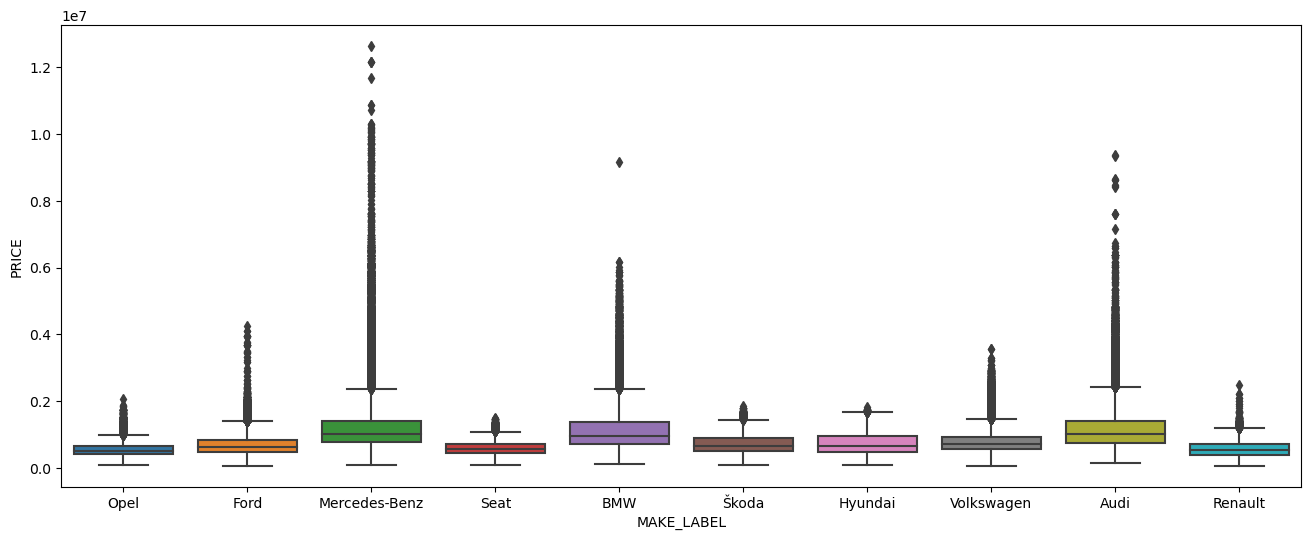

In [72]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data[data['MAKE_LABEL'].isin(top_10_makes.index)]['MAKE_LABEL'], \
            y = data[data['MAKE_LABEL'].isin(top_10_makes.index)]['PRICE'])

### Model
The make stands for a particular model of a car. Below we show top 10 by number of records and top 10 makes by number of unique models. 

In [187]:
data.groupby(['MODEL'])[['PRICE']].count().sort_values(by = 'PRICE', ascending = False).head(10)

,PRICE
MODEL,
MAKE_VOLKSWAGEN-MODELFAMILY_GOLF,25564
MAKE_VOLKSWAGEN-MODELFAMILY_T_ROC,13240
MAKE_VOLKSWAGEN-MODELFAMILY_TIGUAN,11859
MAKE_OPEL-MODELFAMILY_CORSA,11407
MAKE_AUDI-MODELFAMILY_A3,10716
MAKE_VOLKSWAGEN-MODELFAMILY_POLO,9222
MAKE_FORD-MODELFAMILY_FOCUS,8853
MAKE_AUDI-MODELFAMILY_A4,8784
MAKE_AUDI-MODELFAMILY_A6,8368


### Cubic Capacity of Engine
The cubic capacity of an engine, often referred to as "engine displacement" or simply "displacement," is the total volume of all the cylinders in an engine. It is typically measured in cubic centimeters (cc) or liters (L) and represents the space available inside the engine's cylinders for air and fuel. 

On the chart below, we clearly see that price, on average, dramatically increases after cubic capacity of 3000cc.

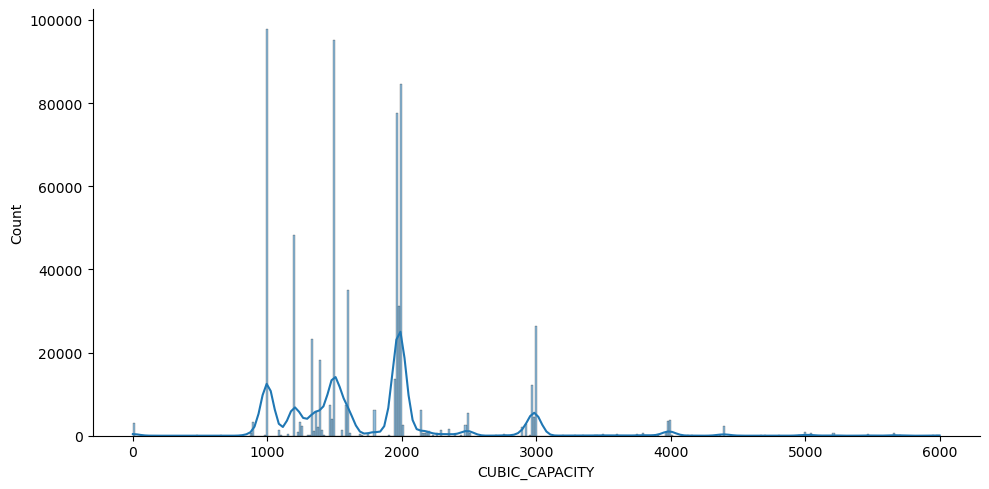

In [16]:
sns.displot(data[data['CUBIC_CAPACITY'] < 6000]['CUBIC_CAPACITY'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='CUBIC_CAPACITY', ylabel='PRICE'>

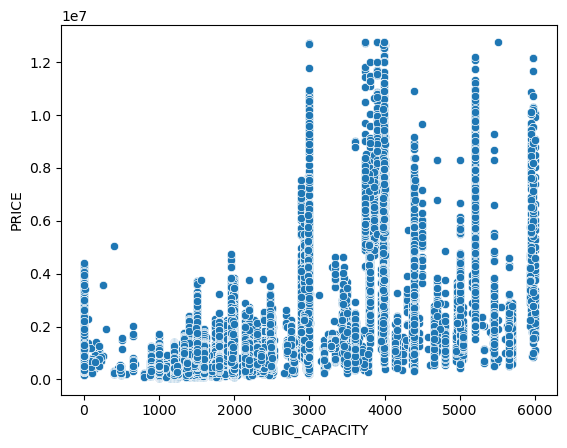

In [17]:
sns.scatterplot(x = data[data['CUBIC_CAPACITY'] < 6000]['CUBIC_CAPACITY'], y = data[data['CUBIC_CAPACITY'] < 6000]['PRICE'] )

### Power (kw)
This power is commonly measured in horsepower (hp) or kilowatts (kW) and is a key factor in a car's performance, including its ability to accelerate, climb hills, and maintain high speeds.

The diagram below shows clear correlation between power and price.

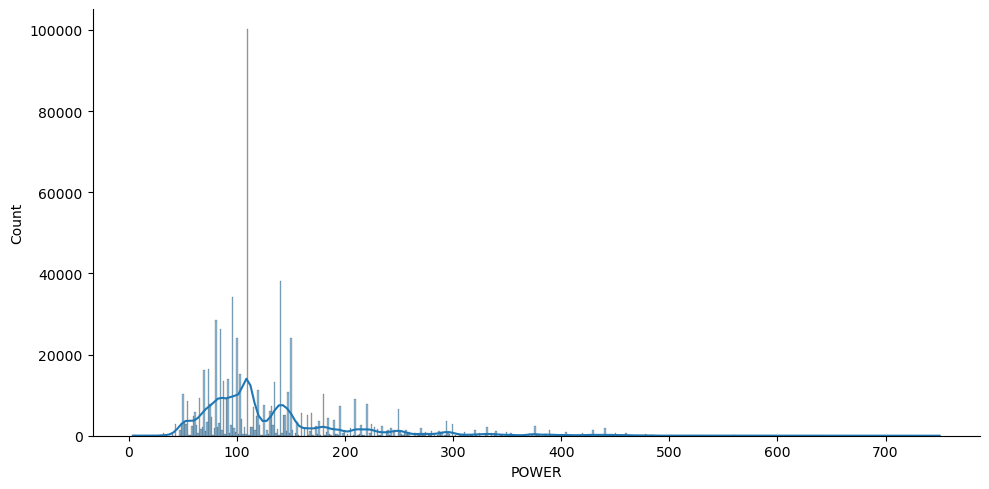

In [151]:
sns.displot(data['POWER'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='POWER', ylabel='PRICE'>

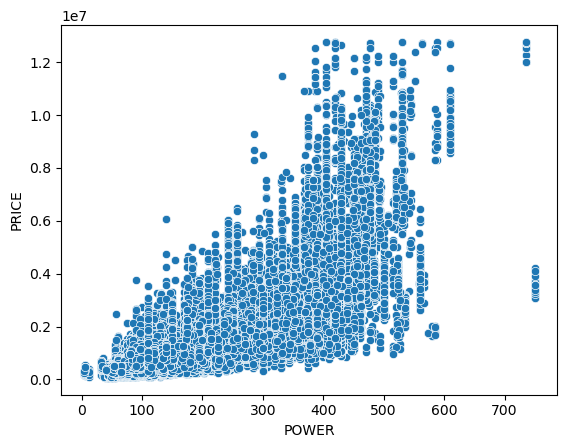

In [18]:
sns.scatterplot(x = data['POWER'], y = data['PRICE'] )

### Number of Seats
In the dataset there were a coubple of listings with number of seats >= 50 which its not typical for cars. Thus, it makes sense to ignore such values. The cars with over 5 seats apper to be less pricy. as The average price decreases after that level. Since the majoriy of cars have less than 5 seats, the feature is not likely to be important in further analysis.

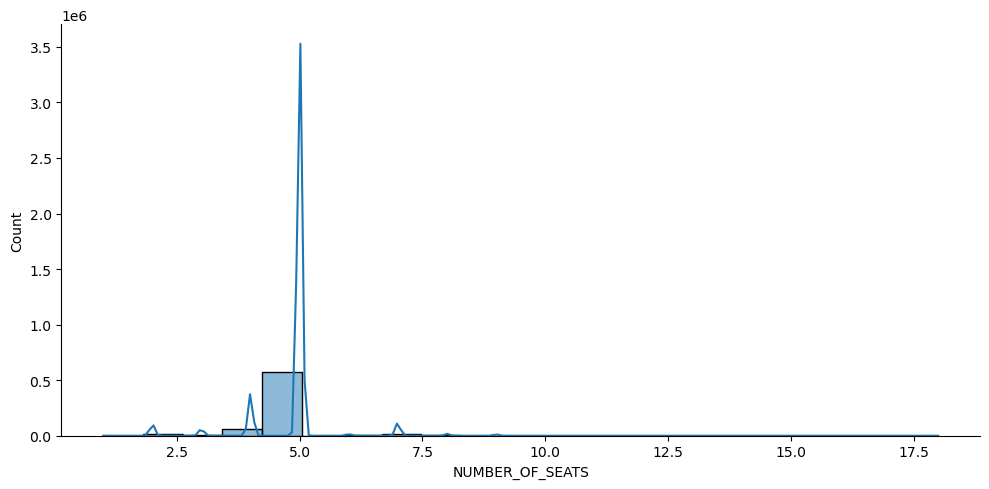

In [153]:
sns.displot(data[data['NUMBER_OF_SEATS'] < 50]['NUMBER_OF_SEATS'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='NUMBER_OF_SEATS', ylabel='PRICE'>

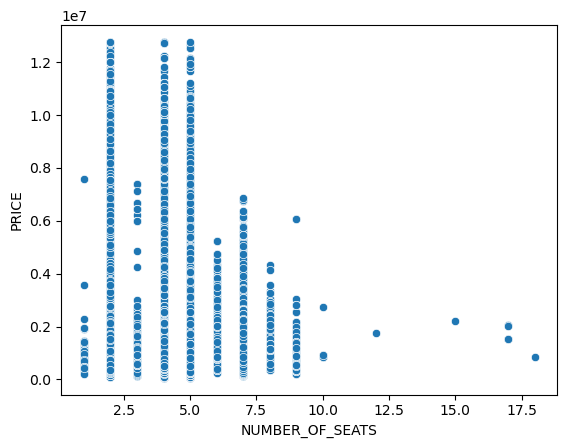

In [23]:
sns.scatterplot(x = data[data['NUMBER_OF_SEATS'] < 50]['NUMBER_OF_SEATS'], y = data[data['NUMBER_OF_SEATS'] < 50]['PRICE'])

### Fuel Consumtion
The terms "FUEL_CONSUMPTION_EXTRA_URBAN," "FUEL_CONSUMPTION_URBAN," and "FUEL_CONSUMPTION_COMBINED" are often used in vehicle specifications to describe how efficiently a car uses fuel under different driving conditions. These metrics are usually expressed in liters per 100 kilometers (
L/100 km
L/100 km) or miles per gallon (
mpg
mpg), depending on the region.

On average, cars with the values over 10 litres per 100 kilomeres tend to be priced higher.

In [31]:
fr_consumtion = data[(data['FUEL_CONSUMPTION_COMBINED'] < 40) & 
                     (data['FUEL_CONSUMPTION_EXTRA_URBAN'] < 40) & \
                     (data['FUEL_CONSUMPTION_URBAN'] < 40)]

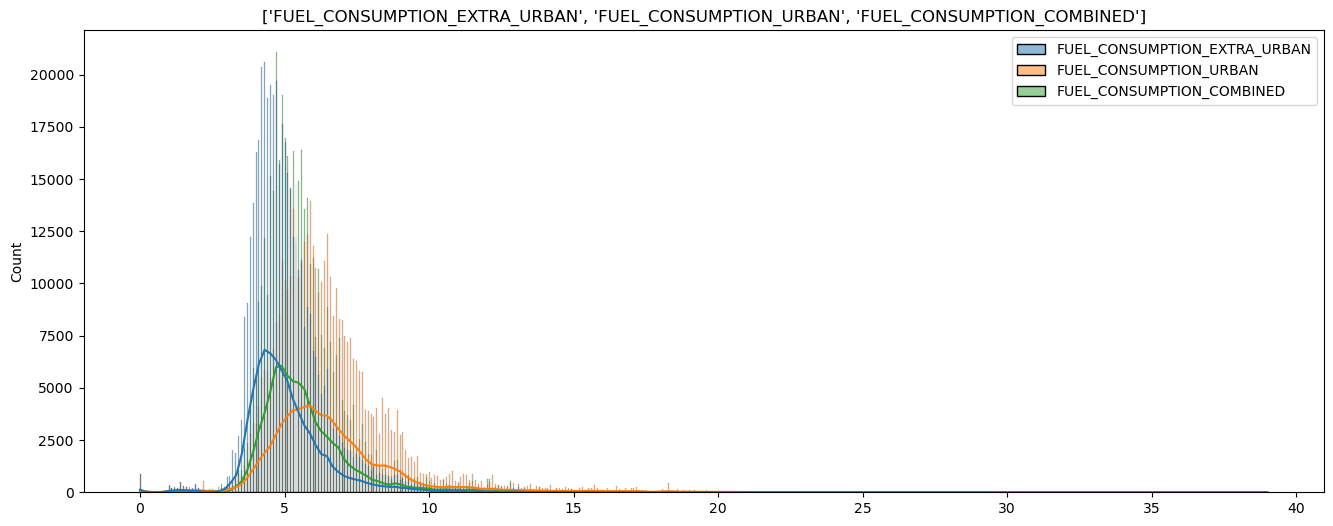

In [34]:
build_histogram(fr_consumtion,['FUEL_CONSUMPTION_EXTRA_URBAN', 'FUEL_CONSUMPTION_URBAN', 'FUEL_CONSUMPTION_COMBINED'])

<AxesSubplot:xlabel='FUEL_CONSUMPTION_COMBINED', ylabel='PRICE'>

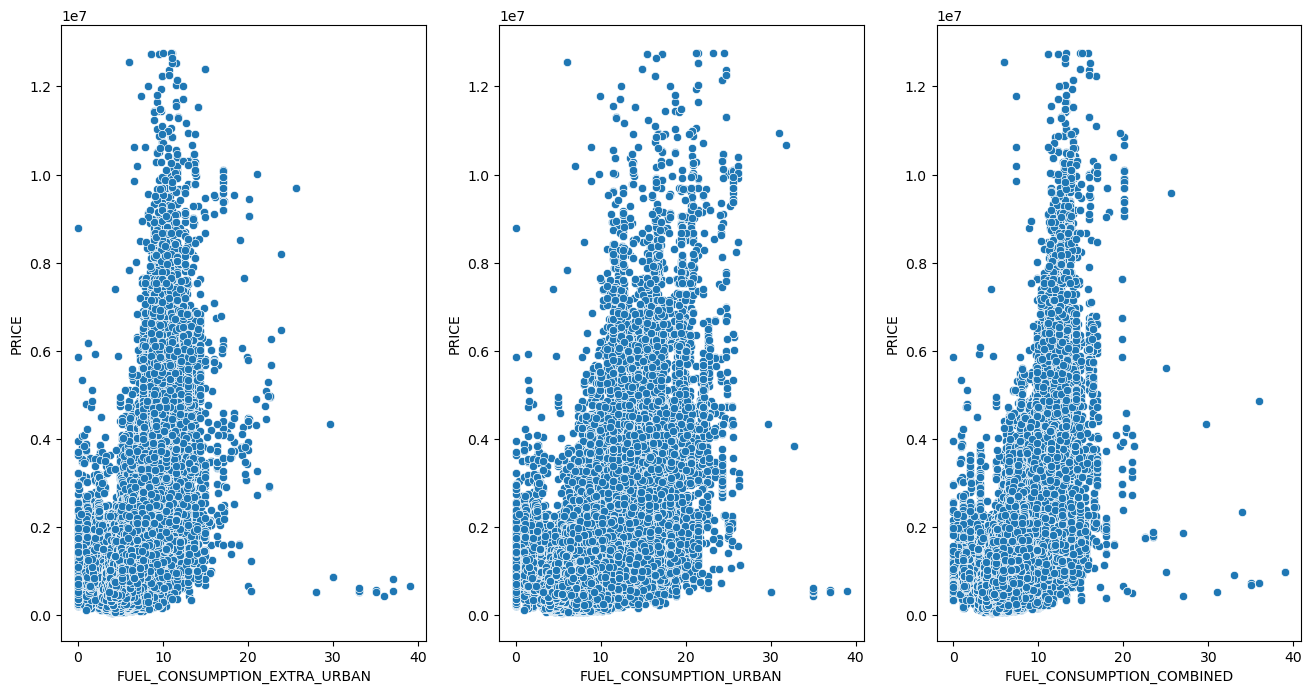

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16, 8))

sns.scatterplot(x = fr_consumtion['FUEL_CONSUMPTION_EXTRA_URBAN'], \
                y = fr_consumtion['PRICE'], ax=axes[0])
sns.scatterplot(x = fr_consumtion['FUEL_CONSUMPTION_URBAN'], \
                y = fr_consumtion['PRICE'], ax=axes[1])
sns.scatterplot(x = fr_consumtion['FUEL_CONSUMPTION_COMBINED'], \
                y = fr_consumtion['PRICE'], ax=axes[2])

### Weight

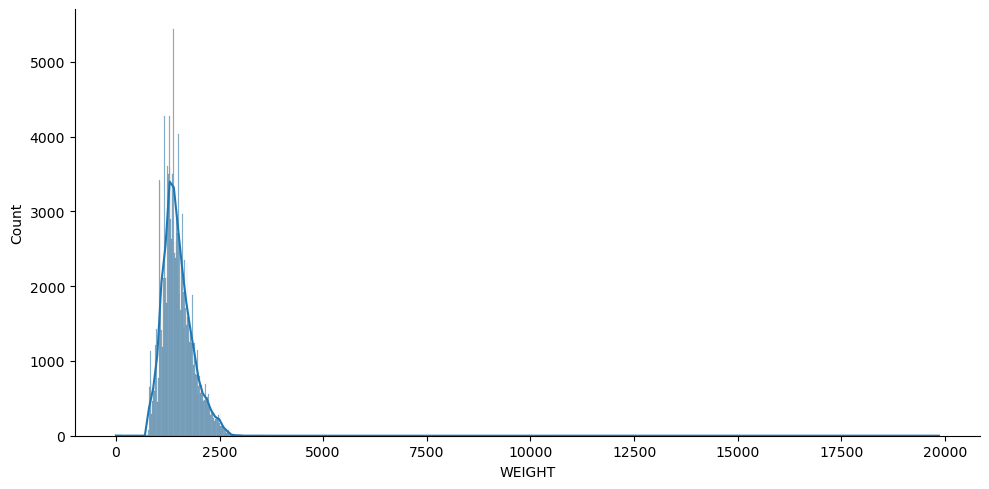

In [154]:
sns.displot(data['WEIGHT'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='WEIGHT', ylabel='PRICE'>

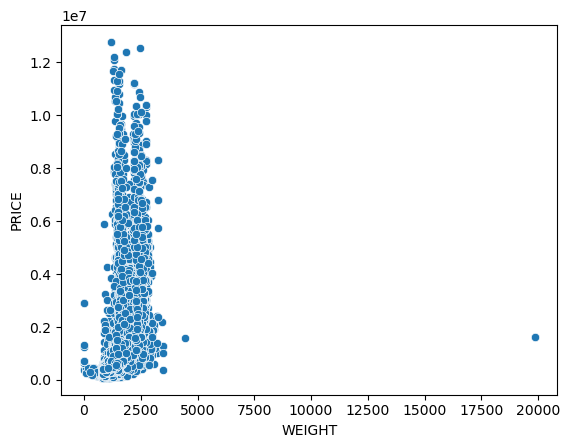

In [26]:
sns.scatterplot(x = data['WEIGHT'], y = data['PRICE'] )

### Number of Gears
The number of gears refers to the number of gears of the stepped gear transmission. The number of manual gearboxes is mostly 5 or 6 gears, while the automatic gears are mostly 4-8 gears, some cars are also equipped with 9-speed and 10-speed gearboxes.

Cars with 6-7 gears tend to have higher price.

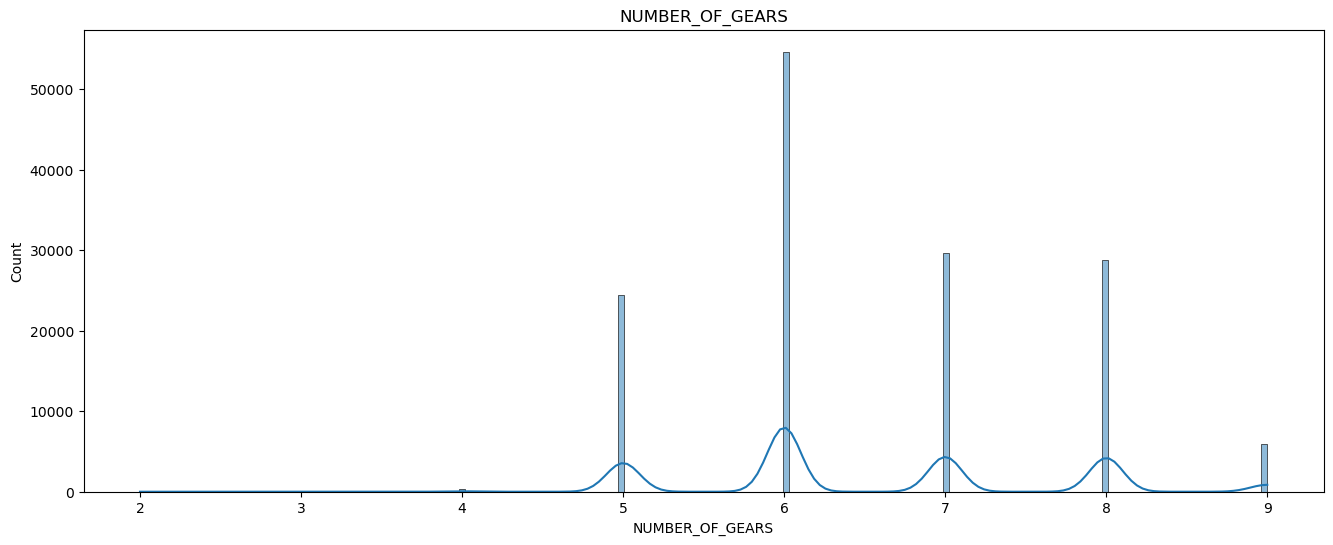

In [115]:
build_histogram(data, 'NUMBER_OF_GEARS')

<AxesSubplot:xlabel='NUMBER_OF_GEARS', ylabel='PRICE'>

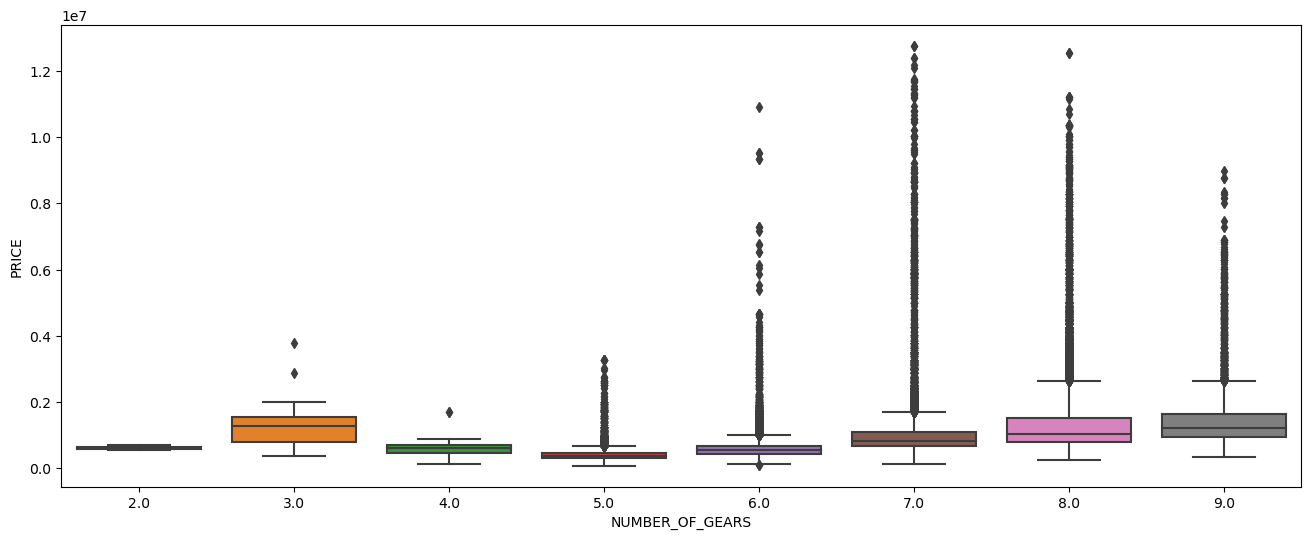

In [53]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['NUMBER_OF_GEARS'], y = data['PRICE'])

### Carbon Dioxide Emission
The relation between CO2 emission and price is the followoing: price seem to be higher on average for cars with higher emission. probably, because more powerful engines generate more CO2.

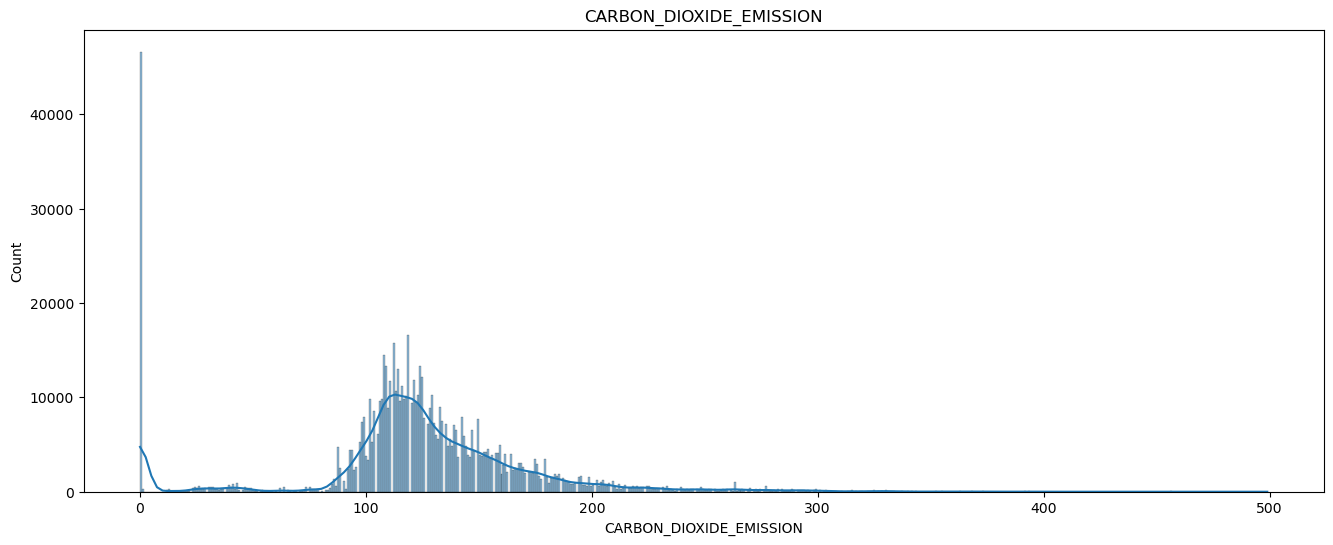

In [114]:
build_histogram(data[data['CARBON_DIOXIDE_EMISSION'] < 500], 'CARBON_DIOXIDE_EMISSION')

<AxesSubplot:xlabel='CARBON_DIOXIDE_EMISSION', ylabel='PRICE'>

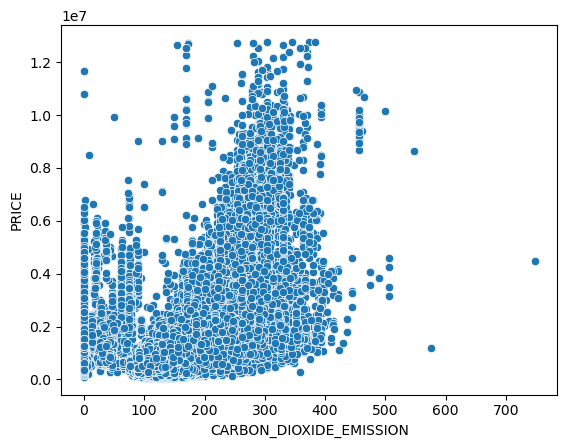

In [47]:
sns.scatterplot(x = data[data['CARBON_DIOXIDE_EMISSION'] < 800]['CARBON_DIOXIDE_EMISSION'], \
                y =  data[data['CARBON_DIOXIDE_EMISSION'] < 800]['PRICE'])

### Manufacture Year
The difference in price relatively to the manufacture year becomes noticible for cars manufactures >5 years ago. For more recently manafuctured cars, price does not seem to vary a lot.

<Figure size 1600x600 with 0 Axes>

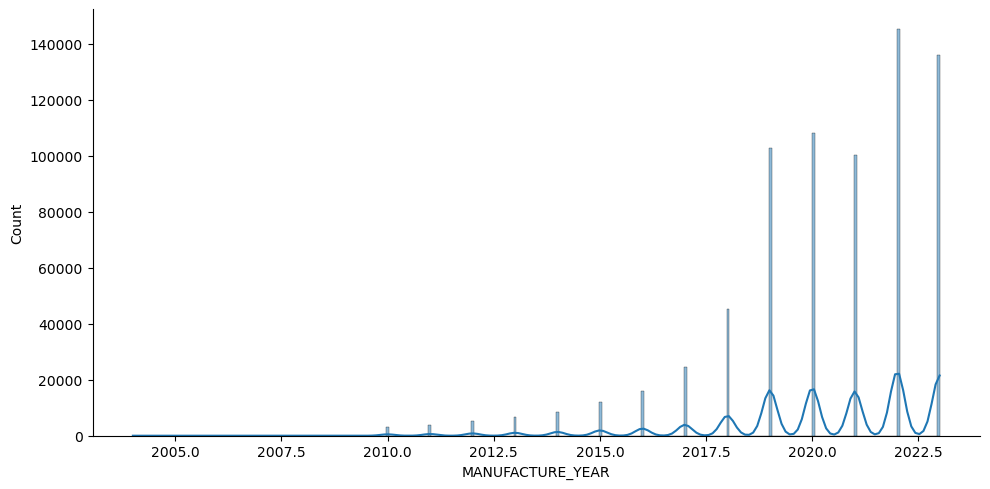

In [159]:
plt.figure(figsize=(16, 6)) 
sns.displot(data['MANUFACTURE_YEAR'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='MANUFACTURE_YEAR', ylabel='PRICE'>

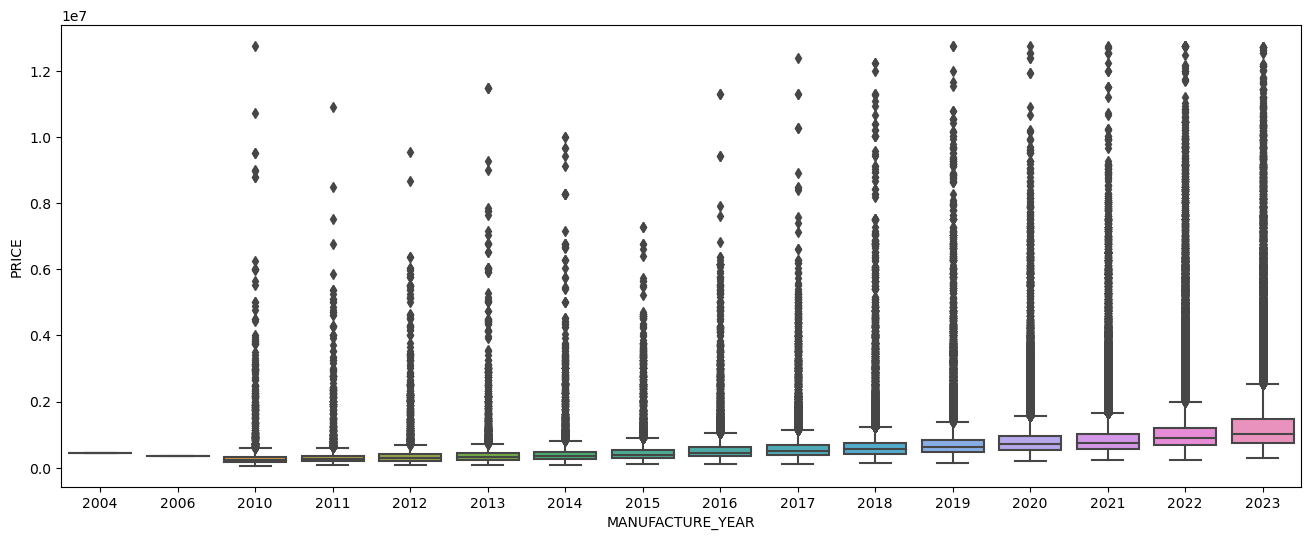

In [52]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['MANUFACTURE_YEAR'], y = data['PRICE'])

### Selling Country


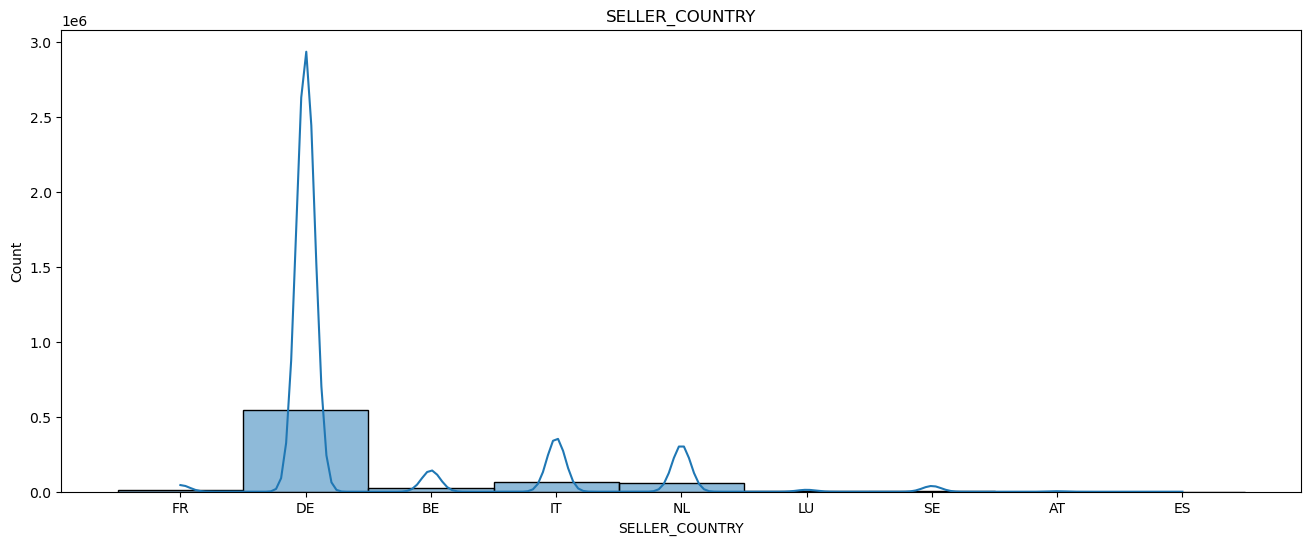

In [118]:
build_histogram(data, 'SELLER_COUNTRY')

### Vehicle Class

A car may be one of the 15 segments:

CSUV (Compact Sport Utility Vehicle) - A smaller-sized SUV that offers versatility in both urban and off-road settings. Examples include the Honda CR-V and the Toyota RAV4.

BSUV (B-segment Sport Utility Vehicle) - These are subcompact SUVs that are smaller than compact SUVs. They are typically more affordable and have less cargo space. Examples include the Ford EcoSport and the Mazda CX-3.

DSUV (D-segment Sport Utility Vehicle) - These are larger SUVs that offer more space and often come with advanced features. Examples include the Ford Edge and the Nissan Murano.

C (C-segment) - Also known as compact cars. They are larger than subcompacts but smaller than mid-size cars. Examples include the Honda Civic and the Ford Focus.

D (D-segment) - Often referred to as large family or mid-size cars. They offer more space and often come with more luxurious features. Examples include the Toyota Camry and the Honda Accord.

B (B-segment) - Also known as subcompact cars. They are smaller than compact cars and are typically more affordable. Examples include the Ford Fiesta and the Honda Fit.

ESUV (E-segment Sport Utility Vehicle) - These are full-sized SUVs that offer maximum space and luxury features. Examples include the Chevrolet Tahoe and the Ford Expedition.

A (A-segment) - These are mini cars or city cars. They are the smallest and are ideal for city driving. Examples include the Fiat 500 and the Chevrolet Spark.

CMPV (Compact Multi-Purpose Vehicle) - These are smaller MPVs or minivans designed for families. They offer versatility in seating and cargo configurations.

E (E-segment) - Also known as executive cars. They are larger than mid-size cars and offer luxury features. Examples include the BMW 5 Series and the Mercedes E-Class.

SPORT - These are sporty vehicles designed primarily for performance rather than practicality. Examples include the Ford Mustang and the Chevrolet Corvette.

COMMERCIAL - These are vehicles designed for business purposes, such as vans and trucks.

BMPV (B-segment Multi-Purpose Vehicle) - These are subcompact MPVs designed for urban families. They are smaller than CMPVs.

EMPV (E-segment Multi-Purpose Vehicle) - These are larger MPVs that offer maximum space and features for families. Examples include the Chrysler Pacifica and the Honda Odyssey.

F - This could refer to full-sized cars, which are larger than mid-size cars and are typically more luxurious. However, without more context, it's hard to be certain.

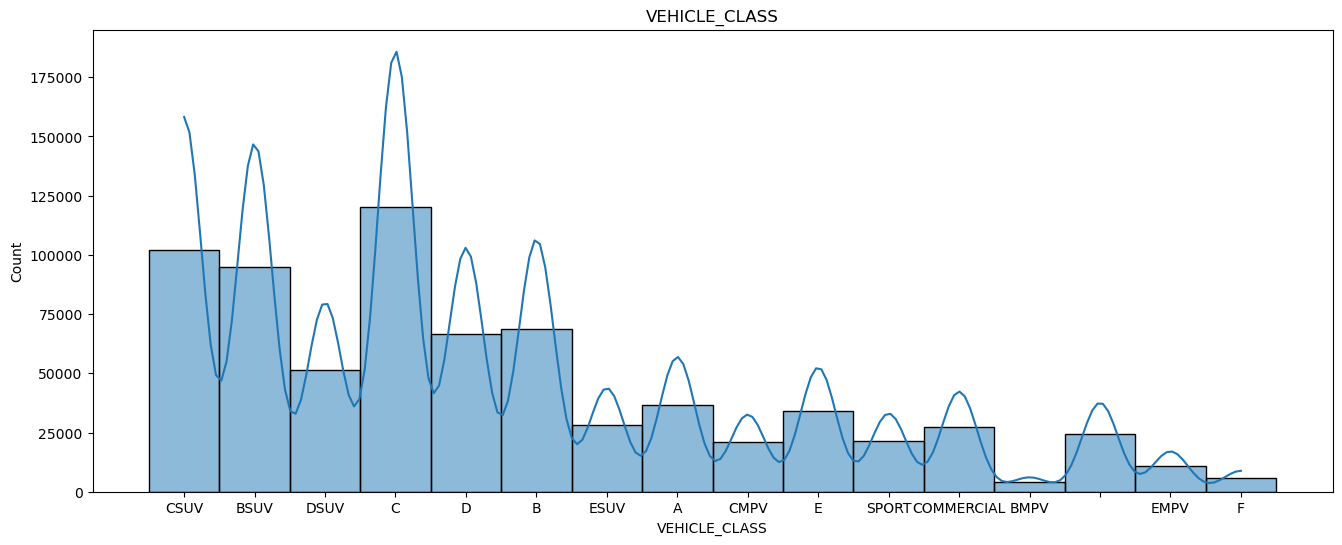

In [76]:
plt.figure(figsize=(16, 6)) 
build_histogram(data, 'VEHICLE_CLASS')

### VAT reclaimable

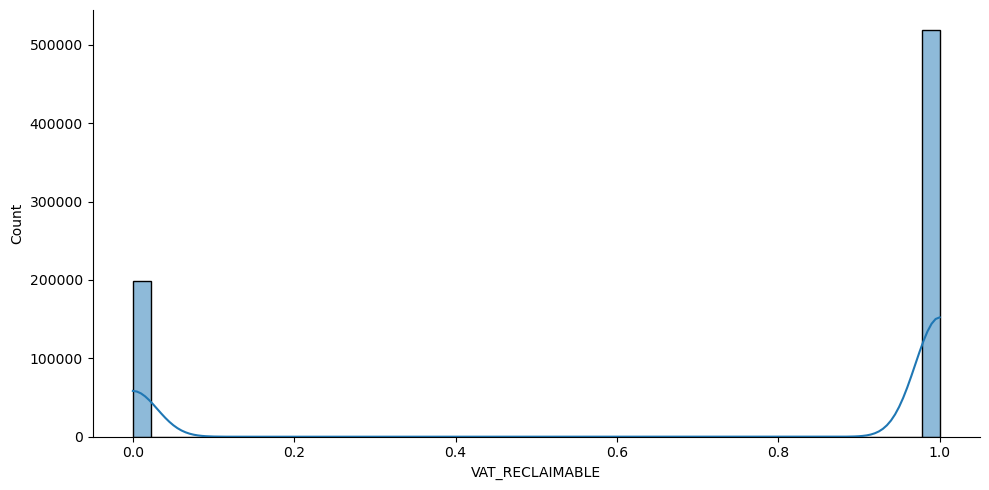

In [158]:
sns.displot(data['VAT_RECLAIMABLE'], kde=True, aspect = ASPECT)

### POWER (HP)
"hp" stands for horsepower, which is a unit of power used to measure the output of engines, particularly in cars. In the automotive context, horsepower is a measure of the engine's ability to produce work over time. 

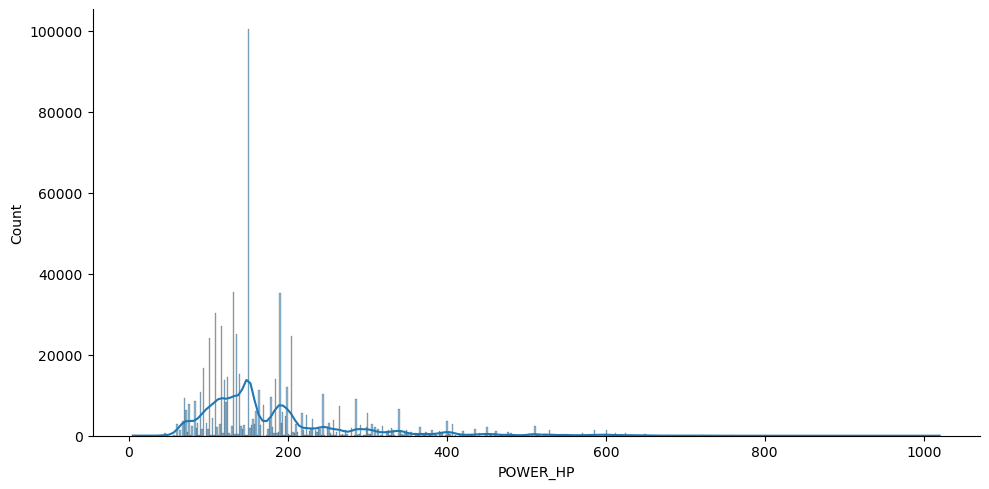

In [160]:
sns.displot(data['POWER_HP'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='POWER_HP', ylabel='PRICE'>

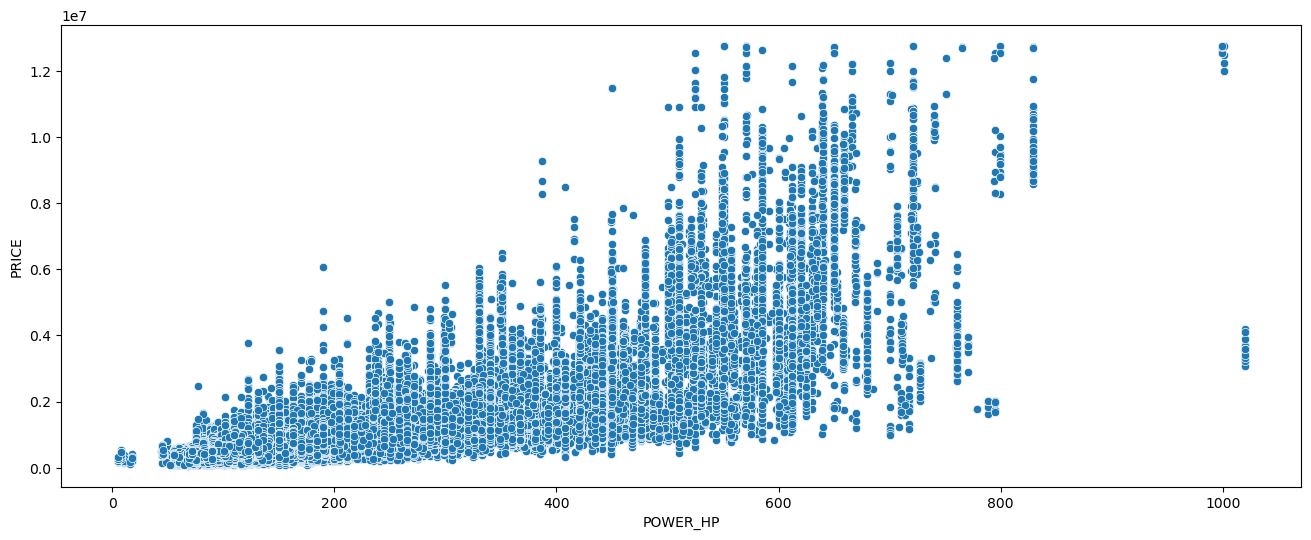

In [56]:
plt.figure(figsize=(16, 6)) 
sns.scatterplot(x = data['POWER_HP'], y = data['PRICE'])

### FUEL TYPE
The fuel type id correspond to a type of fuel listed in the table below.

In [164]:
fuel_type

,id,const_key,name
0,1,FUELTYPE_PETROL,Petrol
1,2,FUELTYPE_DIESEL,Diesel
2,3,FUELTYPE_ELECTRIC,Electric
3,4,FUELTYPE_LPG,LPG
4,5,FUELTYPE_CNG,CNG
5,6,FUELTYPE_HYBRID,Hybrid
6,7,FUELTYPE_OTHER,Other fuel type
7,8,FUELTYPE_HYDROGEN,Hydrogen
8,9,FUELTYPE_ETHANOL,Ethanol


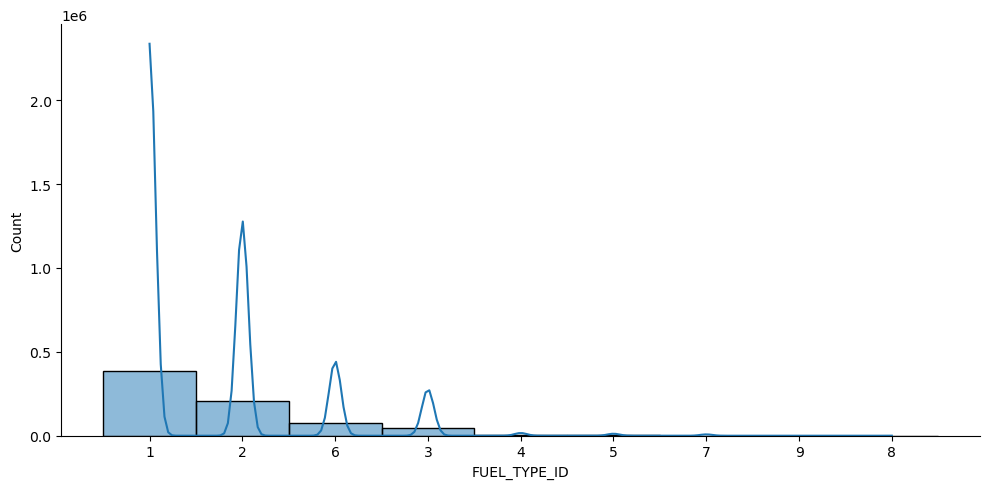

In [161]:
sns.displot(data['FUEL_TYPE_ID'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='FUEL_TYPE_ID', ylabel='PRICE'>

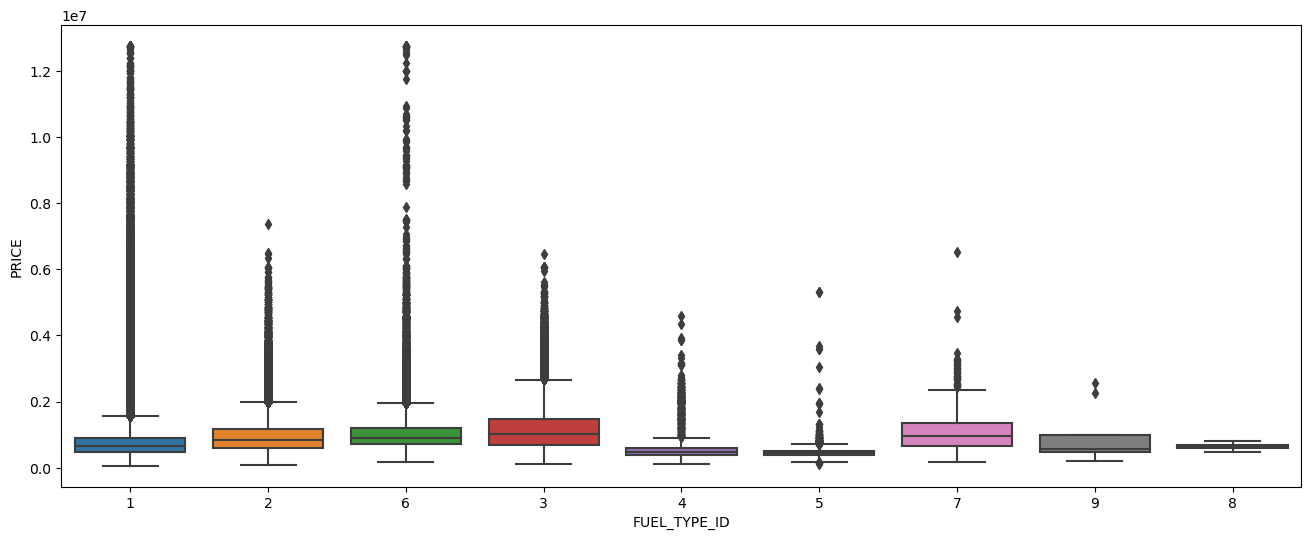

In [55]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['FUEL_TYPE_ID'], y = data['PRICE'])

### Car Styles
The car style id correspond to a type of car style listed in the table below.

In [169]:
car_style

,id,const_key,name
0,1,CARSTYLE_COMPACT,Compact
1,2,CARSTYLE_SEDANS_SALOONS,Sedans / saloons
2,3,CARSTYLE_ESTATE_CAR,Station Wagon
3,4,CARSTYLE_SUV_OFFROAD,SUV / offroad
4,5,VANSTYLE_VAN,Cargo VAN
5,6,CARSTYLE_COUPE,Coupe
6,7,CARSTYLE_CABRIOLET,Cabriolet
7,8,CARSTYLE_VAN,MPV/VAN
8,9,CARSTYLE_PICK_UP,Pick-up
9,10,CARSTYLE_OTHER,Other car styles


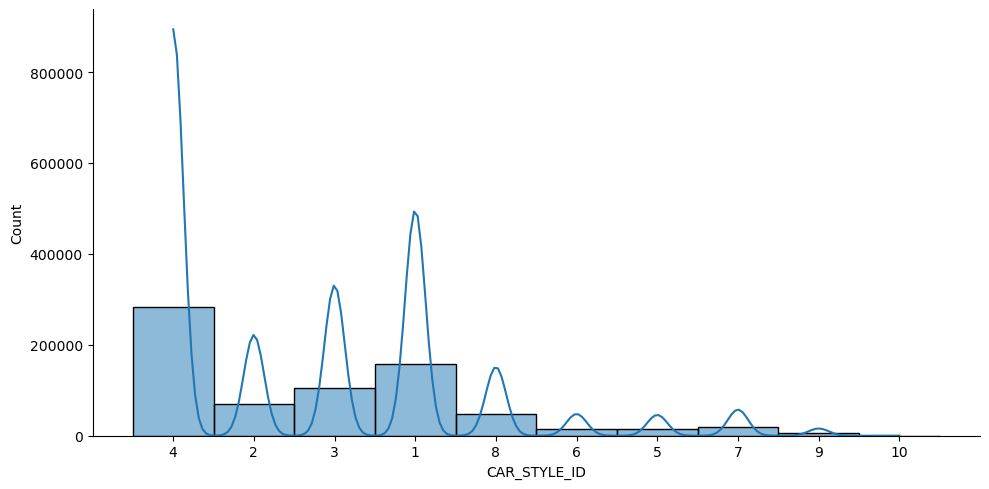

In [170]:
sns.displot(data['CAR_STYLE_ID'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='CAR_STYLE_ID', ylabel='PRICE'>

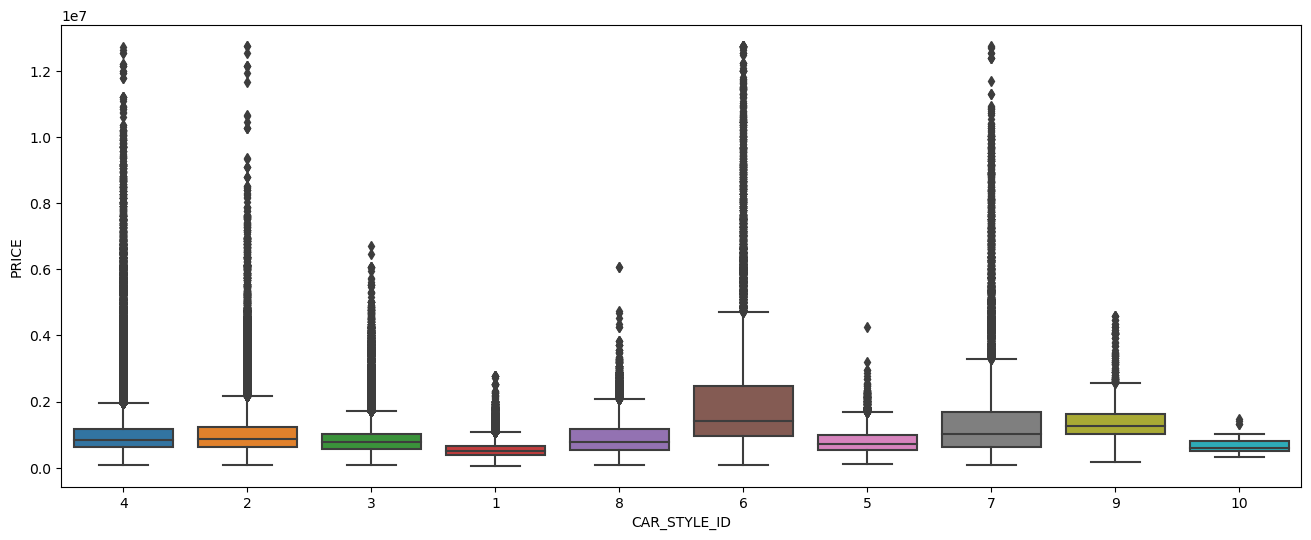

In [57]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['CAR_STYLE_ID'], y = data['PRICE'])

### Emission Class
The emission class id correspond to an emission class listed in the table below.

In [172]:
emission_class

,id,const_key,name
0,1,EMISSIONCLASS_NONE,No emission class
1,2,EMISSIONCLASS_1,Euro 1
2,3,EMISSIONCLASS_2,Euro 2
3,4,EMISSIONCLASS_3,Euro 3
4,5,EMISSIONCLASS_4,Euro 4
5,6,EMISSIONCLASS_5,Euro 5
6,7,EMISSIONCLASS_6,Euro 6
7,8,EMISSIONCLASS_6C,Euro 6c
8,9,EMISSIONCLASS_6D_TEMP,Euro 6d-TEMP
9,10,EMISSIONCLASS_6D,Euro 6d


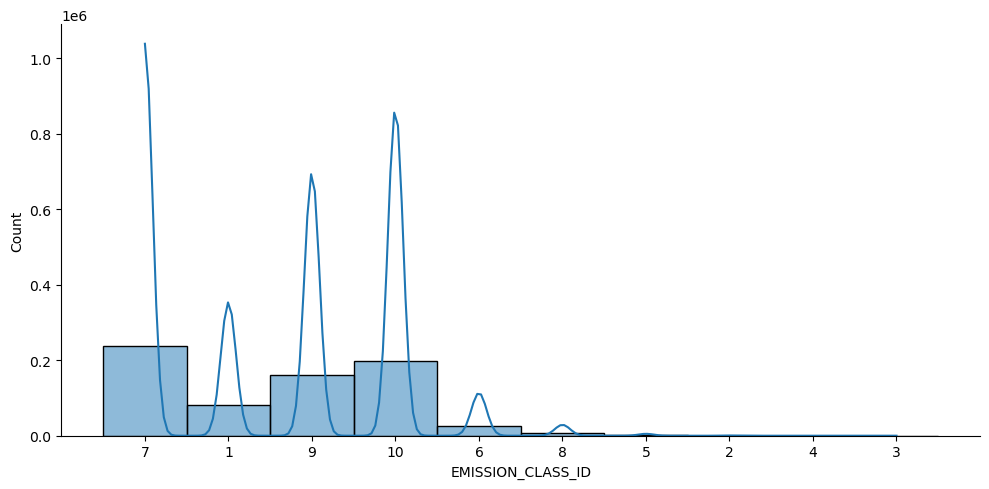

In [173]:
sns.displot(data['EMISSION_CLASS_ID'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='EMISSION_CLASS_ID', ylabel='PRICE'>

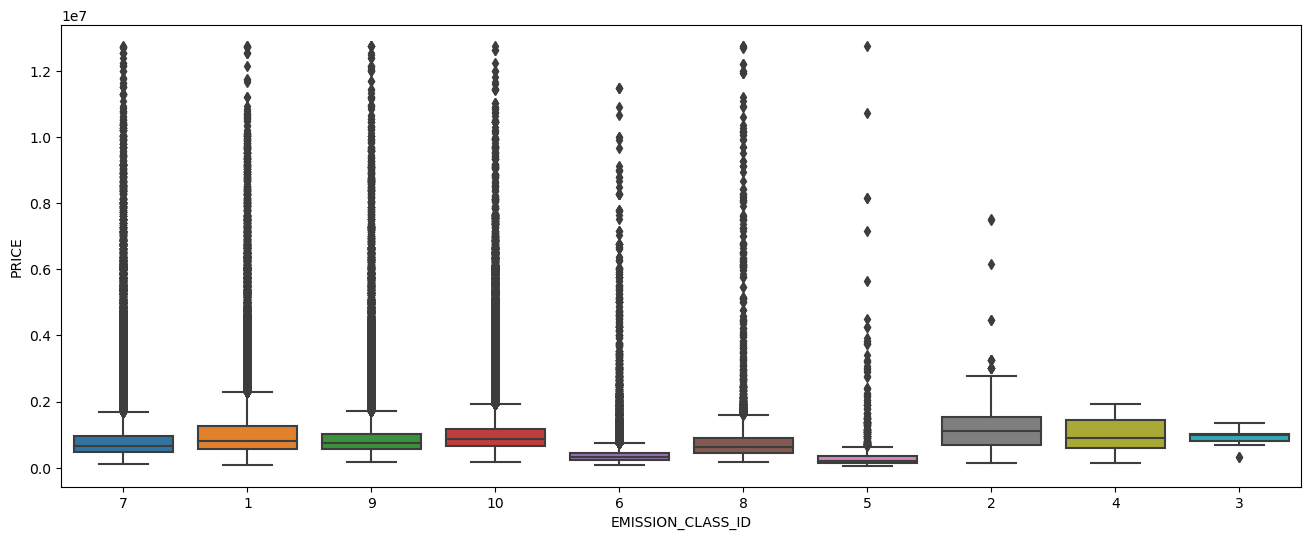

In [58]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['EMISSION_CLASS_ID'], y = data['PRICE'])

### Drive
"1" corresponds to Front wheel drive (FWD)
"3" corresponds to 4x4 (Four-wheel drive)
"4" corresponds to 4x2 (Two-wheel drive, likely rear-wheel drive in this context)

Price for two-weel drive tends to be higher than that for ffour-weel drive.

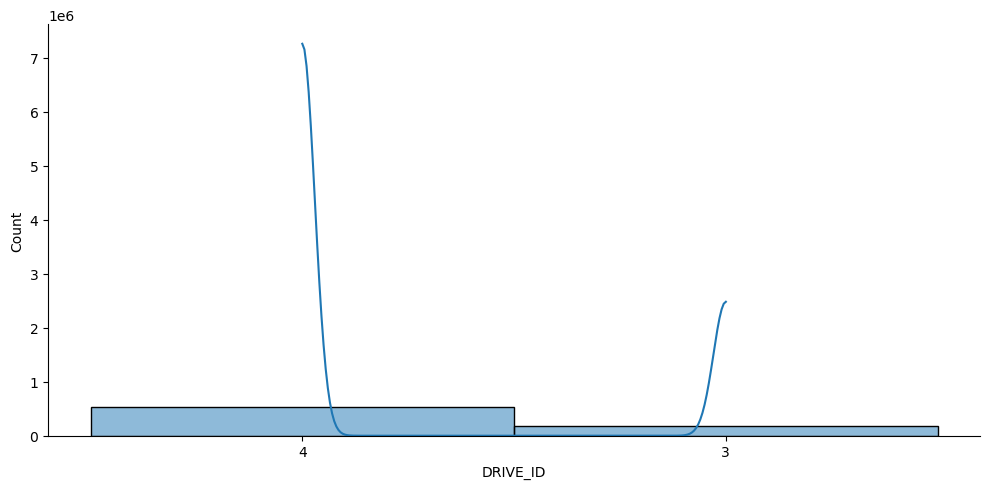

In [176]:
sns.displot(data['DRIVE_ID'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='DRIVE_ID', ylabel='PRICE'>

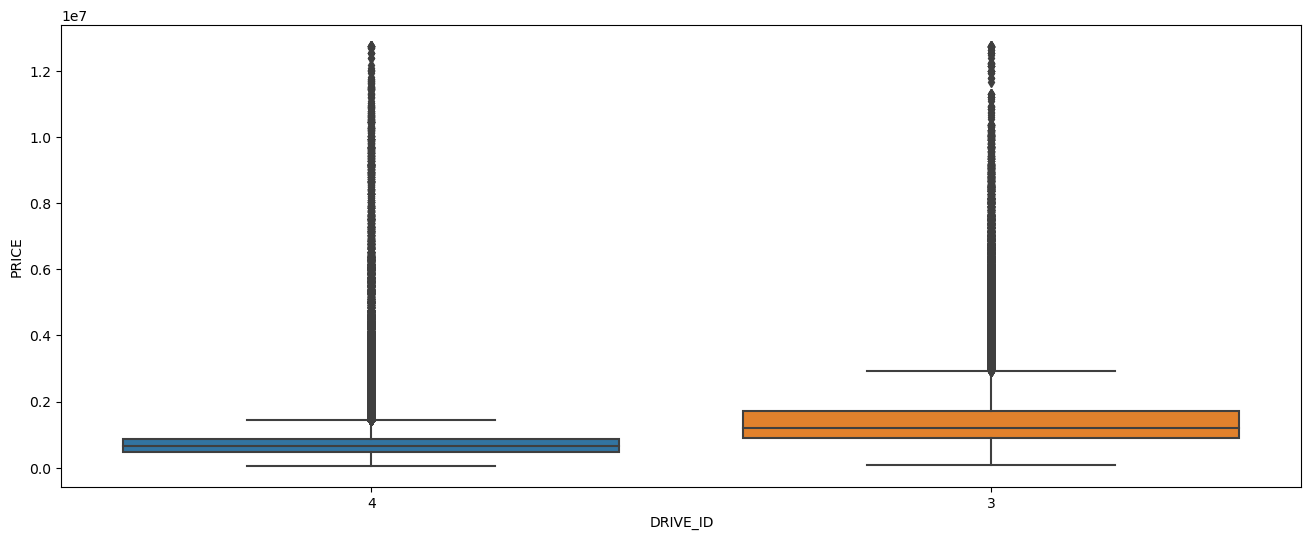

In [59]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['DRIVE_ID'], y = data['PRICE'])

### Transmission
Currently there are more cars with automatic transmission, and their price is,on average, higher.

In [199]:
transmission

,id,const_key,name
0,1,TRANSMISSION_MANUAL,Manual
1,2,TRANSMISSION_AUTOMATIC,Automatic


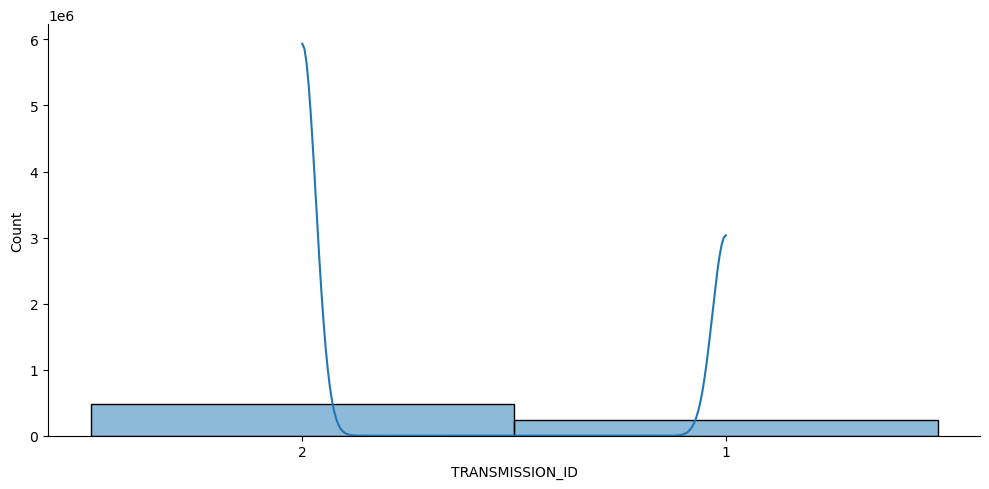

In [196]:
sns.displot(data['TRANSMISSION_ID'], kde=True, aspect = ASPECT)

<AxesSubplot:xlabel='TRANSMISSION_ID', ylabel='PRICE'>

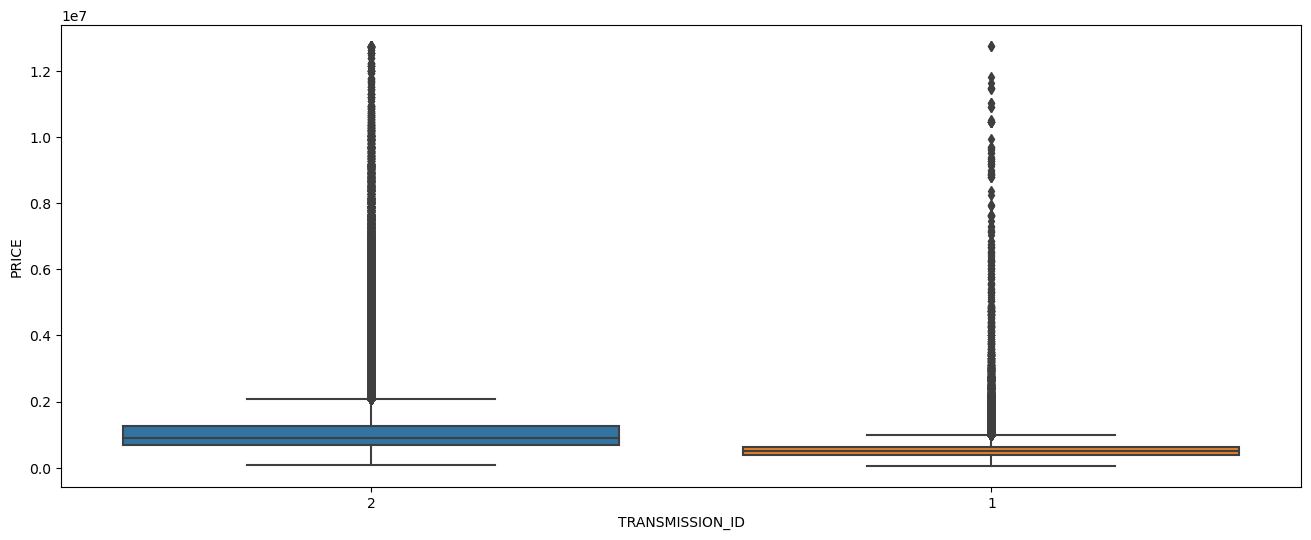

In [60]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['TRANSMISSION_ID'], y = data['PRICE'])

### Seleller Type
Majority of cars are listed by professional car dealerships, and dealership set the highest prices, on average, in comprison to used cars sellers and private sellers.

This feature is not relevant for the model to estimate car price, as it is not linekd to the technical parameters of a car, but may be useful to understand existing pricing in the market. It is probable that dealers might have power to influence the price due to their market share. 

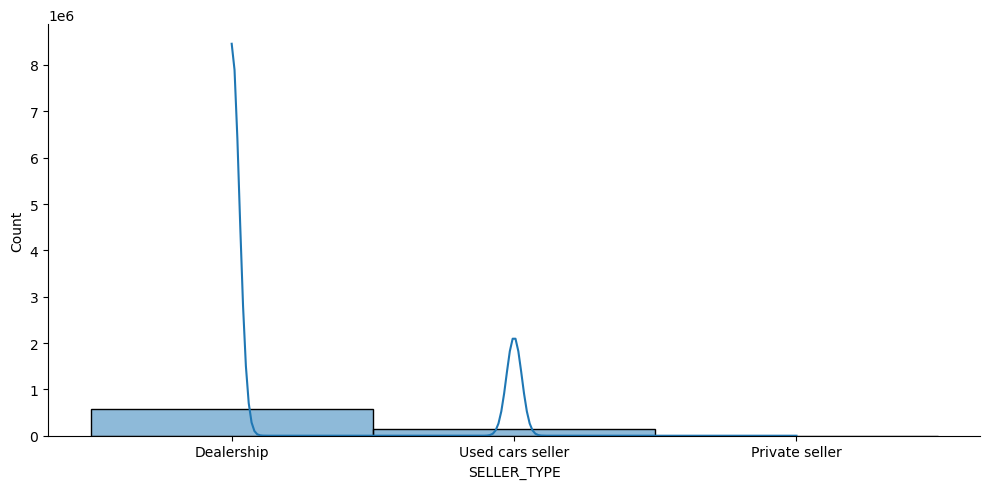

In [200]:
sns.displot(data['SELLER_TYPE'], kde=True, aspect = ASPECT)

Text(0.5, 1.0, 'Price by seller type')

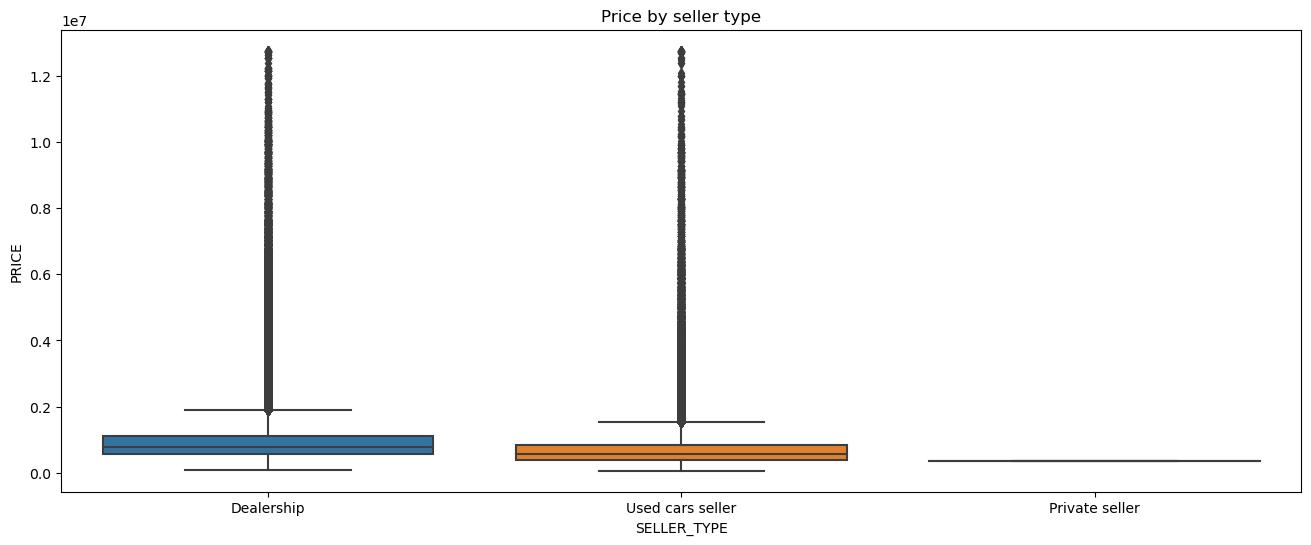

In [76]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['SELLER_TYPE'], y = data['PRICE']).set_title('Price by seller type')

Text(0.5, 1.0, 'Mileage by seller type')

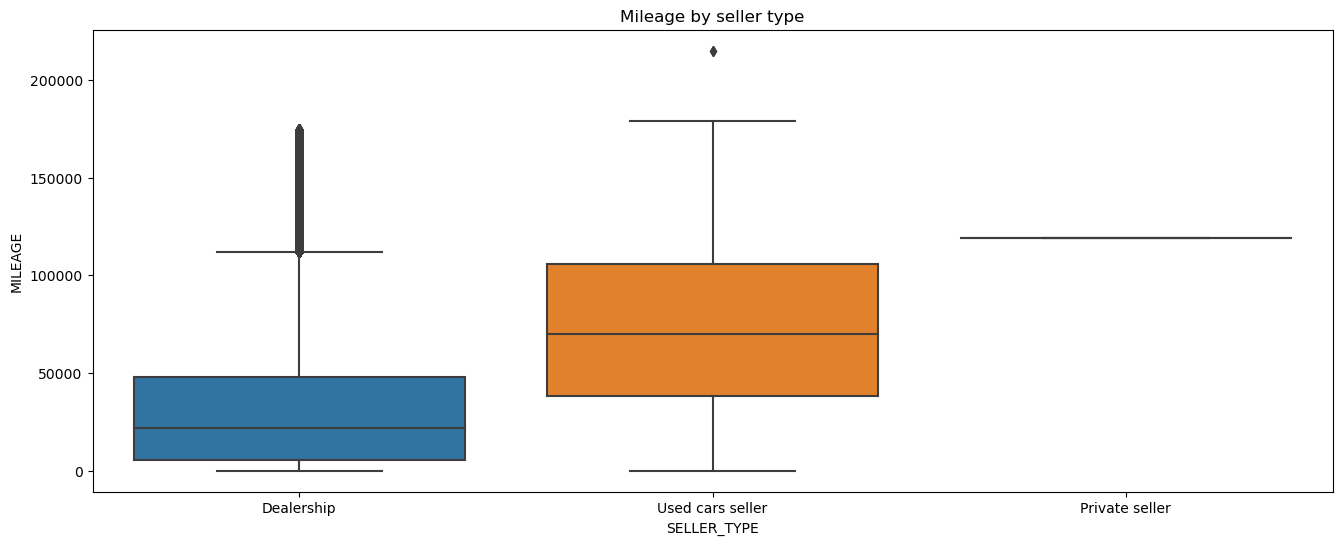

In [75]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['SELLER_TYPE'], y = data['MILEAGE']).set_title('Mileage by seller type')

### Mileage (km)
Mileage indicates the total number of kilometers that a car has traveled. As expected, mileage is inversely related to the price.

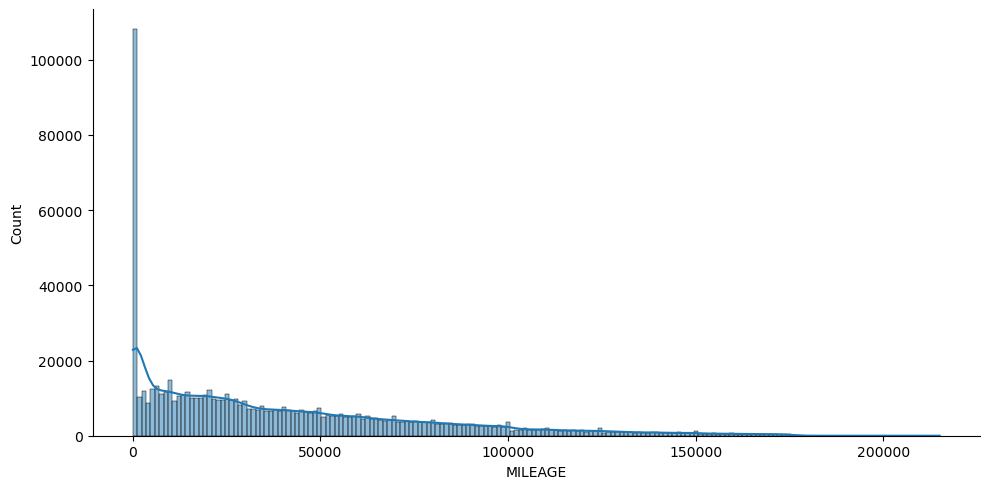

In [206]:
sns.displot(data['MILEAGE'], kde=True, aspect = ASPECT)

Text(0.5, 1.0, 'Price and Mileage')

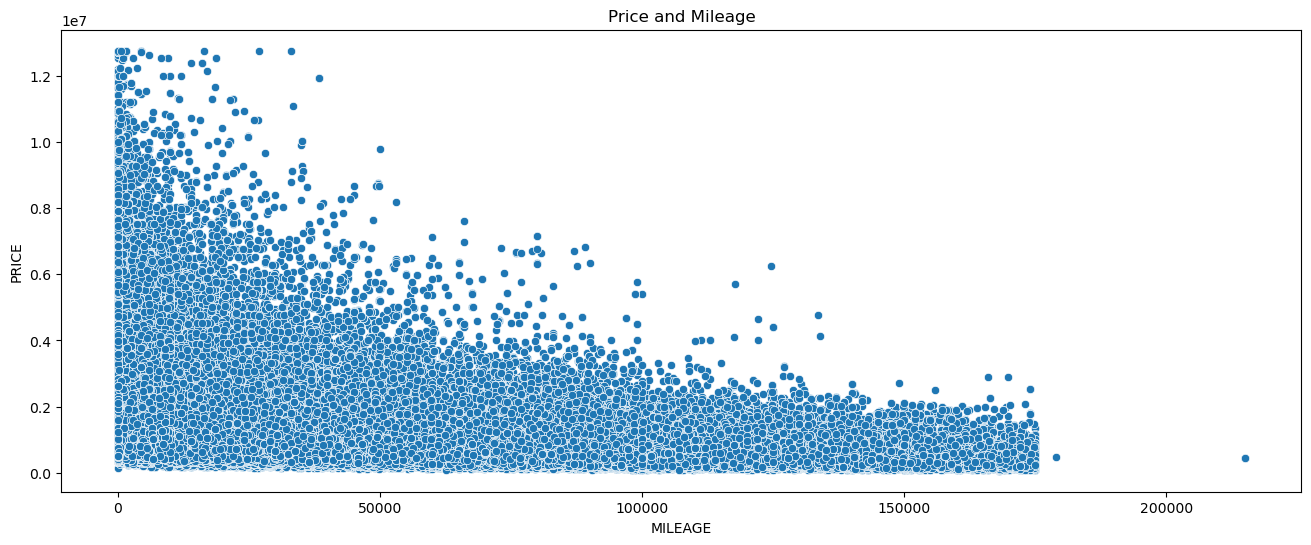

In [79]:
plt.figure(figsize=(16, 6)) 
sns.scatterplot(x = data['MILEAGE'], y = data['PRICE']).set_title('Price and Mileage')

### Interior Material
Most cars have interior made of cloth. Cars with interior made of leather tens to have higher price, on average.

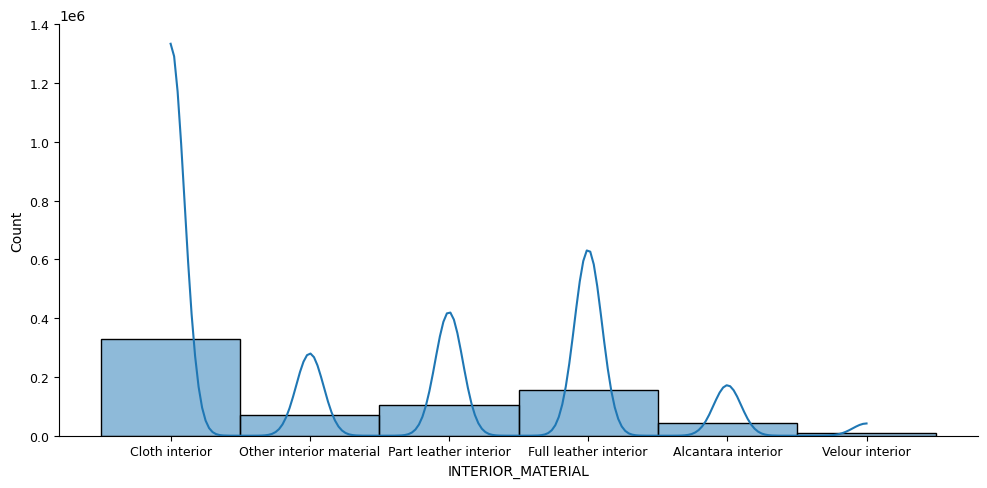

In [211]:
sns.displot(data['INTERIOR_MATERIAL'], kde=True, aspect = ASPECT)
plt.tick_params(axis='both', which='major', labelsize=9)

Text(0.5, 1.0, 'Price Interior Material')

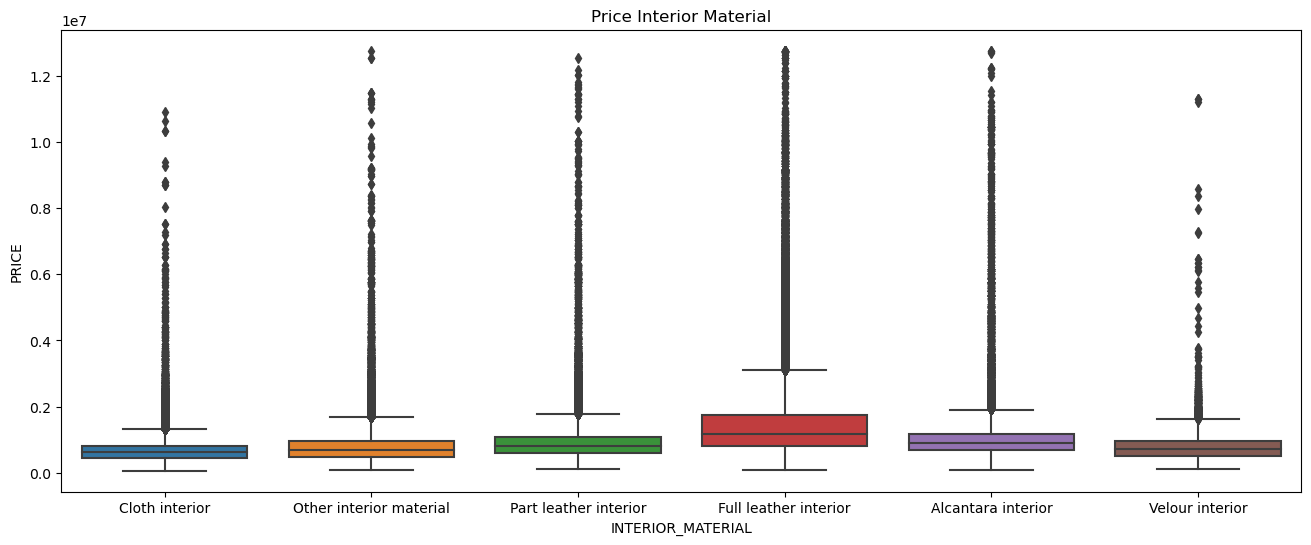

In [81]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['INTERIOR_MATERIAL'], y = data['PRICE']).set_title('Price Interior Material')

### Seller Country
Seller indicates the country in which the car is sold. We observe a disbalace: majority of cars are located in Germany. Apparently, the car aggregator collects data primary from German car selling websites. This feature is not likely to impact price a lot since there is no sufficient variability.

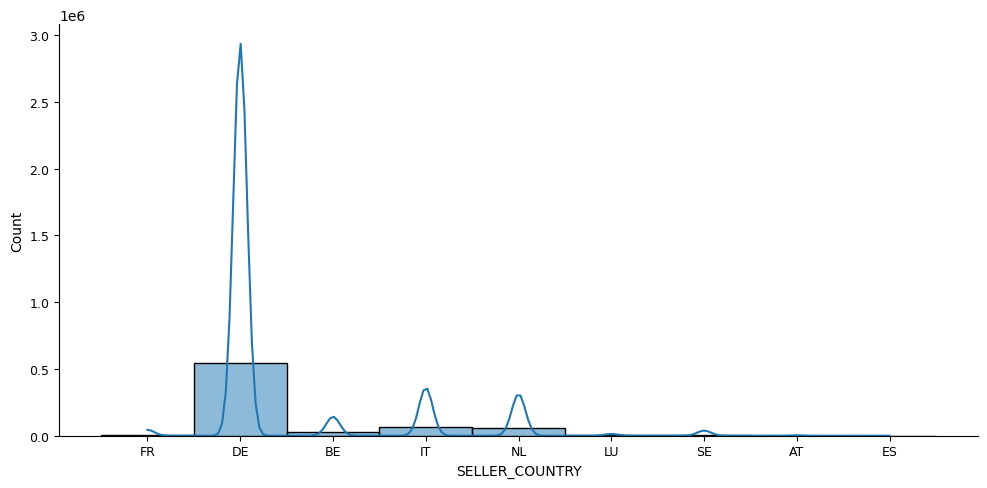

In [121]:
sns.displot(data['SELLER_COUNTRY'], kde=True, aspect = ASPECT)
plt.tick_params(axis='both', which='major', labelsize=9)

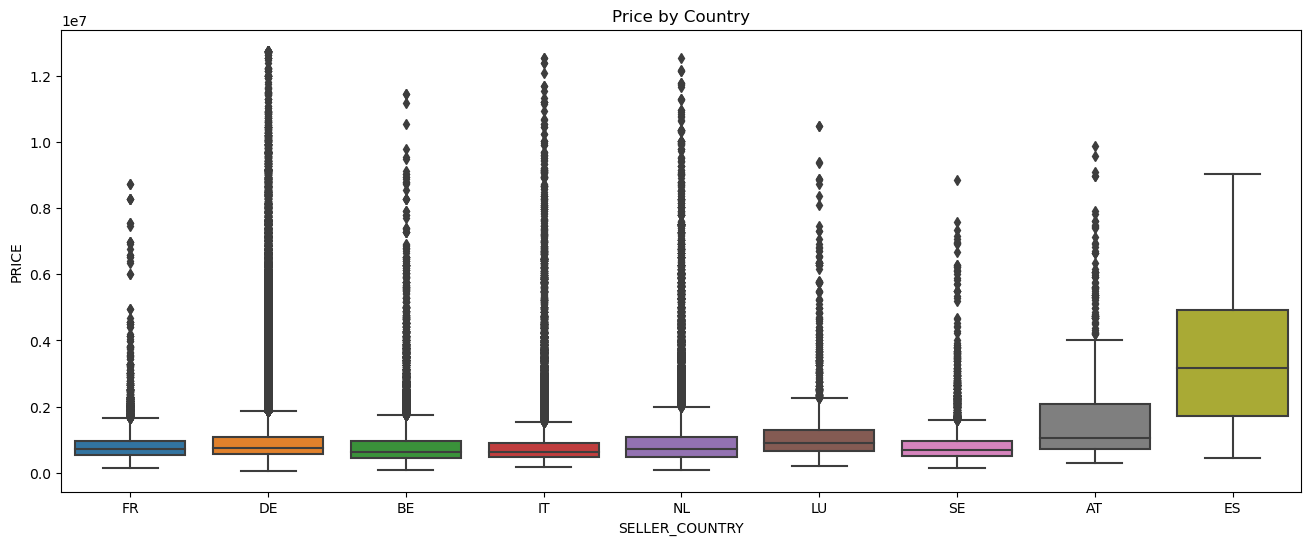

In [126]:
plt.figure(figsize=(16, 6)) 
sns.boxplot(x = data['SELLER_COUNTRY'], y = data['PRICE']).set_title('Price by Country')
plt.show()

### Additional Features

Apart from features mentioned before, cars also have additional functionalities. Thy are listed in the columns 'FEATURES_ID'. Every id corresponds to a festure listed in the table below. First of all, it is logicall to make a hypothesis that numebr of these additional features has correlation with price. On the chart below we can observe positive relation between the two values.

For the baseline model, I will use the number of features variable in order to avoid using too many variables, and in future I plan to conduct a deeper analysis of impact of additional features on car price.

In [15]:
features

,id,const_key,name
0,3,FEATURE_MP3_INTERFACE,MP3 interface
1,4,FEATURE_SPORT_PACKAGE,Sport package
2,5,FEATURE_DIESEL_PARTICULATE_FILTER,Diesel Particulate Filter
3,9,FEATURE_FULL_SERVICE_HISTORY,Full service history
4,10,FEATURE_SERVICE_BOOK,Service book
...,...,...,...
135,167,FEATURE_SPORT_EXHAUST_SYSTEM,Sport-exhaust system
136,168,FEATURE_ADJUSTABLE_STEERING_WHEEL,Adjustable steering wheel
137,169,FEATURE_HEADLAMP_WASHERS,Headlamp washers
138,171,FEATURE_ACCIDENT_VEHICLE,Not roadworthy


In [7]:
data['FEATURE_NUM'] = data['FEATURES_ID'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Price and Number of Features')

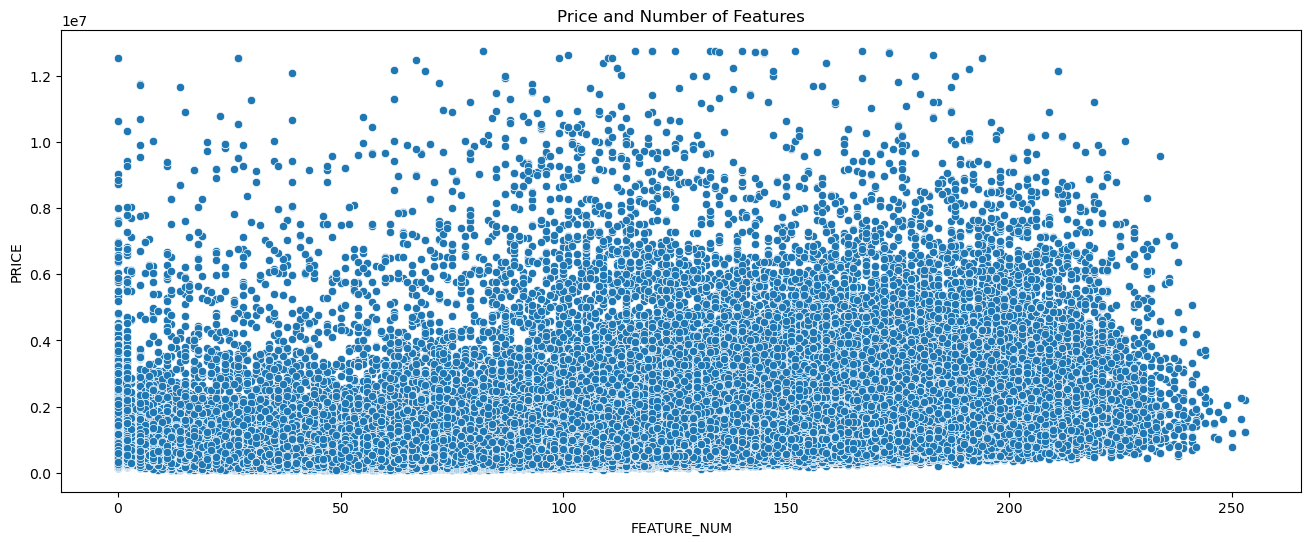

In [99]:
plt.figure(figsize=(16, 6)) 
sns.scatterplot(x = data['FEATURE_NUM'], y = data['PRICE']).set_title('Price and Number of Features')

# Compulsory And optional Features <a id='7'></a>

In this section I define the cumpulsory and optional characteristics to fill in in the applicaion. The cumpolsory characteristics include the main determinants of car price such as model and engine power. A user may not know values of some of these features while they may have an impact on the price (see correlation matrix below). An example is the fuel consumption or CO2 emission that seem to have an impact on pricing, but not every automobile owner knows it by heart. 





**Compulsory Characteristics**
Car Make
Model
Engine Power
Manufacture Year
Transmission Type
Mileage
Number of Gears


**Optional Characteristics**

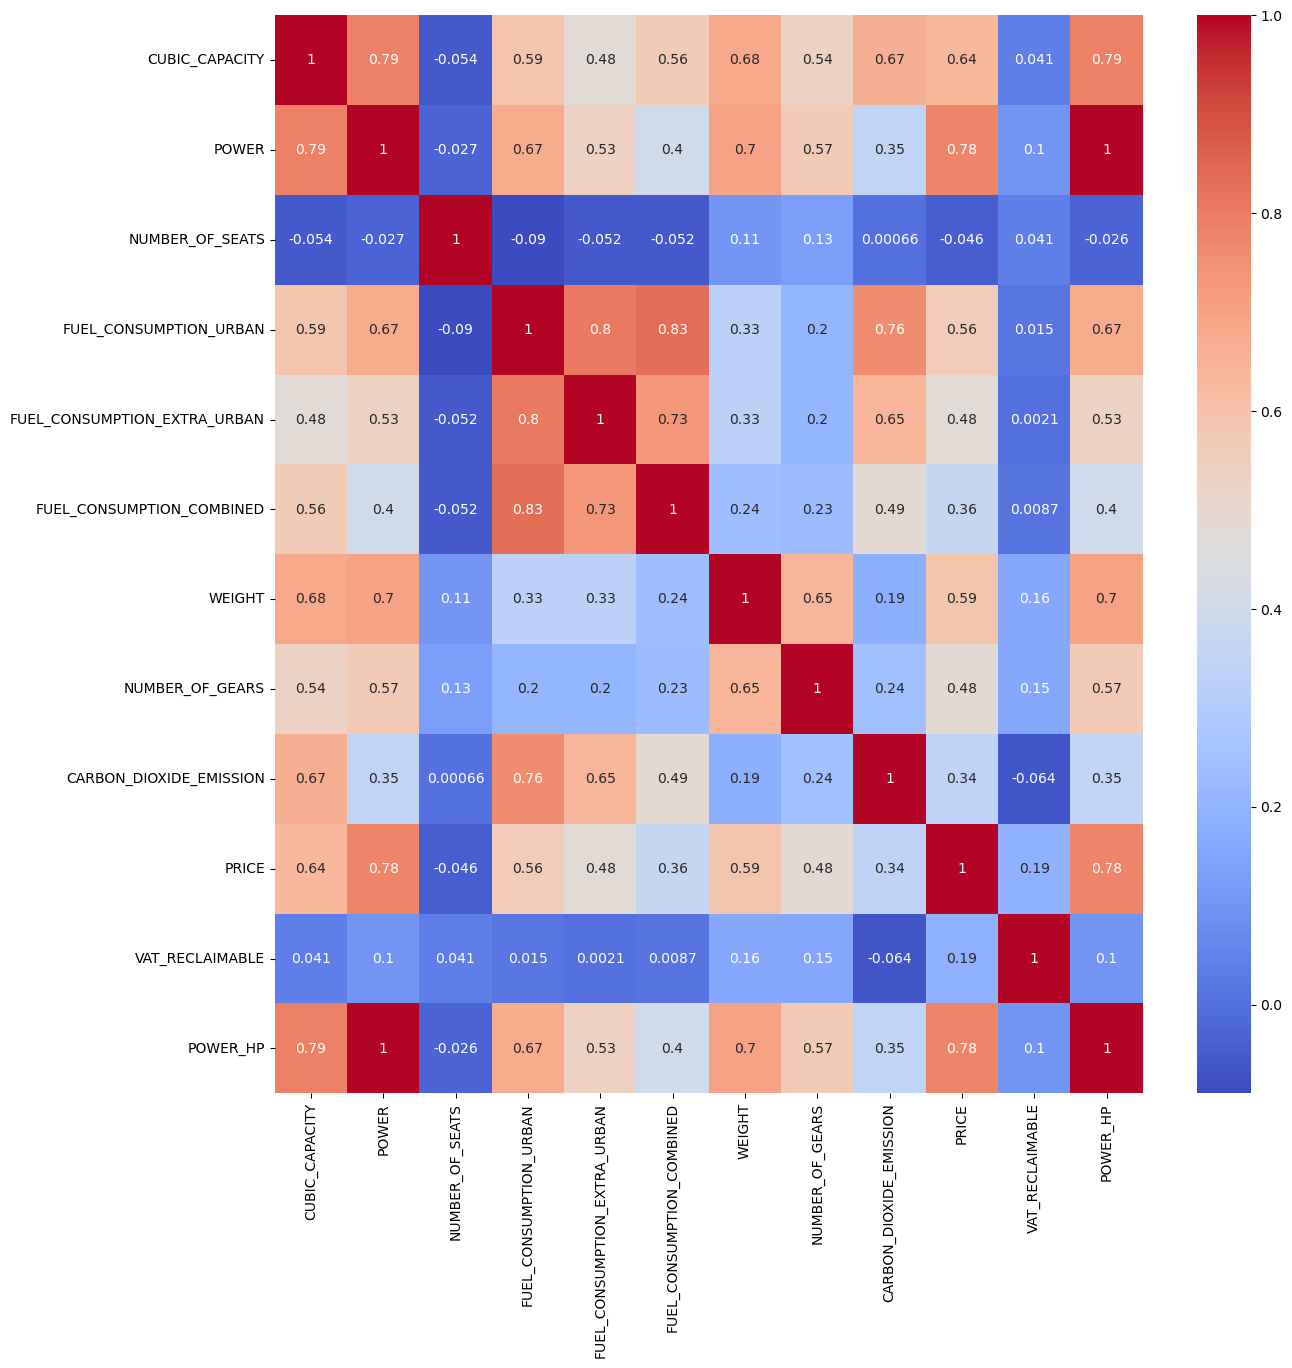

In [28]:
plt.figure(figsize=(14, 14)) 
correlation_matrix = data[[c for c in data.columns]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In order not to leave fields for optional characteristics empty, which might deteriorate model's output, I prropose to introduce default values for the fields that a user does not fill in in the first version of an application. In future, that might be done by means of another machine learning model or a more complex algorithm. 

Below one may see the correlation matrix. We will estimate the empty values of optional characteristics based on the values of compulsory characteristics.

In [19]:
optional_features = [
    'FUEL_CONSUMPTION_URBAN',
    'FUEL_CONSUMPTION_EXTRA_URBAN',
    'FUEL_CONSUMPTION_COMBINED',
    'CARBON_DIOXIDE_EMISSION', 
]

default_values = {feature: data[feature].mean() for feature in optional_features}

In [25]:
with open('optional_features.json', 'w') as f:
    json.dump(default_values, f)

# Categorical And Numerical Features <a id='4'></a>
In this section I define categorical and numberical features that are going to be used in price modeling. In order to process categorical features, I implement one hot encoding.

In [8]:
numerical_features = [
    'VAT_RECLAIMABLE', # only 1 and 0
    'CUBIC_CAPACITY',
    'POWER',
    'NUMBER_OF_SEATS',
    'FUEL_CONSUMPTION_URBAN',
    'FUEL_CONSUMPTION_EXTRA_URBAN',
    'FUEL_CONSUMPTION_COMBINED',
    'WEIGHT',
    'NUMBER_OF_GEARS',
    'CARBON_DIOXIDE_EMISSION', 
    'MILEAGE',
    'MANUFACTURE_YEAR',
    'FEATURE_NUM'
]


categorical_featues = [
    'VEHICLE_CLASS',
    'FUEL_TYPE_ID',
    'CAR_STYLE_ID',
    'EMISSION_CLASS_ID',
    'DRIVE_ID',
    'MAKE_LABEL',
    'TRANSMISSION_ID',
    'SELLER_COUNTRY', 
    'INTERIOR_MATERIAL'
]


target = ['PRICE_EUR']


In [9]:
df = data[categorical_featues + numerical_features + target]
df = pd.get_dummies(df, columns=categorical_featues)

# Car Price Prediction XGBoost Regression <a id='5'></a>

In this section I trained a baseline model with different sets of exogenous variables and checked RMSE score using 5-fold cross validation. 

### XGBoost Regression With Available Features
I start the experiment with the basic XGBoost Regression using features listed above. 

In [160]:
X = df[[col for col in df.columns if col != 'PRICE_EUR']]
Y = df['PRICE_EUR']

In [162]:
# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

In [255]:
# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
# Print the average RMSE score for 5 folds
print(f"Cross-Validation RMSE Mean Score: {int(np.mean(-cv_scores))}")

Cross-Validation RMSE Mean Score: 5956


The RMSE is quite high fluctuation around 6k EUR. Let's take a closer look at items for which we have the biggest error. It is possible that there are some particular car models for which the model perform poorly.

The table below show top 20 brands for which the model predicts majority of prices that are significatly different from real listing price (>=5k difference). We see high-end brands on top: Mercedes-Benz, Audi and BMW.

It is possible that prediction can be improved by taking into account specific additional features instead of using their number as was doned up to the moment. High-end brands tend to have a more diverse portfolio of cars which are ferquently different due to additional functions and gadgets such as sensors and parking camera. In the next section I include those features into the dataset.

In [210]:
#Check top 20 makes for which the difference between prediction and the listing price >5k
df_pred = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
df_pred['diff'] = abs(y_pred - y_test)
df_pred = df_pred.sort_values(by = 'diff', ascending = False)
diff = df_pred[df_pred['diff'] > 5000]
models_diff = data[data.index.isin(diff.index)]
models_diff.groupby(['MAKE_LABEL'])[['PRICE']].count().sort_values('PRICE', ascending = False).head(120)

,PRICE
MAKE_LABEL,
Mercedes-Benz,6488
Audi,5974
BMW,5948
Volkswagen,4826
Porsche,1982
...,...
Landwind,1
NIO,1
Haval,1


### Additional Features
In this section I added extra features to the dataset. For example, if a car has Sport package, it has the value 1 in a column '4', etc.

In [15]:
features.head()

,id,const_key,name
0,3,FEATURE_MP3_INTERFACE,MP3 interface
1,4,FEATURE_SPORT_PACKAGE,Sport package
2,5,FEATURE_DIESEL_PARTICULATE_FILTER,Diesel Particulate Filter
3,9,FEATURE_FULL_SERVICE_HISTORY,Full service history
4,10,FEATURE_SERVICE_BOOK,Service book


In [10]:
all_feature_ids = features['id'].values

# Initialize new columns with zeros
for feature_id in all_feature_ids:
    column_name = f"feature_{feature_id}"
    data[column_name] = 0

In [11]:
for index, row in tqdm(data.iterrows()):
    feature_ids = row['FEATURES_ID'].split(',')
    for feature_id in feature_ids:
        column_name = f"feature_{feature_id}"
        if column_name in data.columns:
            data.at[index, column_name] = 1

data.head()

717370it [10:41, 1117.82it/s]


,CUBIC_CAPACITY,POWER,NUMBER_OF_SEATS,FUEL_CONSUMPTION_URBAN,FUEL_CONSUMPTION_EXTRA_URBAN,FUEL_CONSUMPTION_COMBINED,FUEL_CONSUMPTION_UNIT,POWER_UNIT,WEIGHT,NUMBER_OF_GEARS,...,feature_160,feature_162,feature_163,feature_164,feature_166,feature_167,feature_168,feature_169,feature_171,feature_172
0,1199.0,96,5.0,NaN,NaN,6.5,LITER,kW,1626.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,1560.0,88,5.0,NaN,NaN,3.7,LITER,kW,NaN,6.0,...,0,0,0,0,0,0,0,0,0,0
2,1199.0,96,5.0,5.0,5.0,4.9,LITER,kW,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1997.0,155,5.0,5.8,5.8,5.8,LITER,kW,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,1332.0,160,5.0,NaN,NaN,NaN,LITER,kW,1725.0,NaN,...,0,0,0,0,0,0,0,0,0,1


In [12]:
#adding the features as separate columns to the dataframe
additional_features = [f for f in data.columns if f.startswith('feature')]

df = data[categorical_featues + numerical_features + additional_features +target]
df = pd.get_dummies(df, columns=categorical_featues)

After adding the features to the table, the number of columns increases to 294.

### XGBoost Regression With Additional Features

Let's perform once again the 5-fold cross-validation given the new features and excluding the least important features determined by the model.The result has slightly improved: the mean RMSE decreased from 5956 to 5841.

In [20]:
X = df[[col for col in df.columns if col != 'PRICE_EUR' ]]
Y = df['PRICE_EUR']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')


# Print the average RMSE score for 5 folds
print(f"Cross-Validation RMSE Mean Score: {int(np.mean(-cv_scores))}")

Cross-Validation RMSE Mean Score: 5768


### XGBoost Regression With Additional Features And Car Model
In this part of work I added a separate feature for every existing model. If a car is a corresponding model, then it has 1 in a column named with the id of the feature and 0 otherwise. The number of features inccreased up to 1350.

Adding more features allowed to achieve RMSE of 5708 which is lower than the previous result.

In [13]:
one_hot_model = pd.get_dummies(data['MODEL'], prefix='model')
df_model = pd.concat([df, one_hot_model], axis=1)
df_model.shape

(717370, 1350)

In [14]:
X = df_model[[col for col in df_model.columns if col != 'PRICE_EUR' ]]
Y = df_model['PRICE_EUR']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [34]:
X = df_model[[col for col in df_model.columns if col != 'PRICE_EUR' ]]
Y = df_model['PRICE_EUR']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')


# Print the average RMSE score for 5 folds
print(f"Cross-Validation RMSE Mean Score: {int(np.mean(-cv_scores))}")

Cross-Validation RMSE Mean Score: 5708


# Model Finetuning

In this part of the work I use grid serch technique to select parameters for the model to improve its predictive power.

In [19]:
X = df_model[[col for col in df_model.columns if col != 'PRICE_EUR' ]]
Y = df_model['PRICE_EUR']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Create a parameter grid to search for best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 120, 130, 150, 200, 250, 300, 350],
    'learning_rate': [0.005, 0.008, 0.01, 0.03, 0.05, 0.07, 0.8, 0.1],
    'max_depth': [2, 3 , 4, 5, 10, 20, 50, 100, 150, 200]
}

# Create the XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror')

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   n_iter=50, cv=5, n_jobs=4, verbose=2)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters found:  {'n_estimators': 50, 'max_depth': 200, 'learning_rate': 0.07}


In [16]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Perform cross-validation for the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"Cross-Validation RMSE Mean Score: {int(np.mean(-cv_scores))}")

Cross-Validation RMSE Mean Score: 4937


Finally, let us calculate RMSE using the test dataset comprising 215,211 items. The model achieved RMSE of 3,086 on the test set. This implies that, on average, the model's price estimations deviated from the actual listing prices by approximately 3,000 EUR.

In [130]:
#making a prediction on the test set
file_name = "best_model_xgb_reg.pkl"
with open(file_name, 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(X_test)
print(np.sqrt(MSE(y_pred, y_test)))

3086.515544726396


In [ ]:
#saving the model
file_name = "best_model_xgb_reg.pkl"
pickle.dump(xgb_model, open(file_name, "wb"))